# Credit Scorecard Project – Data Cleaning (Training Set)

## 1. Setup & Imports
- Import libraries
- Set plotting styles

In [1]:
import json
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from dateutil.relativedelta import relativedelta

from sklearn.feature_selection import VarianceThreshold

In [2]:
# Display settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

## 2. Load Data
Load the accepted loan dataset from `/data/raw/`; rejected loan data will not be used for modelling.

In [3]:
df_raw = pd.read_csv('../data/raw/accepted_2007_to_2018Q4.csv')

Additionally, a data dictionary has been compiled from two sources available online. Variable category and preliminary leakage detection flags are added after manual examination.

This file will serve as a feature meta file, with transformations done recorded here.

In [4]:
# Load feature meta data 
feature_meta = pd.read_csv('../dictionaries/LC_Dictionary_Clean.csv')

# Variable segmentation 
feature_meta['Variable_Type'].value_counts().sort_index()

Variable_Type
Applicant                                 11
Applicant (Secondary)                     12
Application                               10
Bureau                                     1
Bureau - Amount, Balance                   7
Bureau - Amount, Delq                      2
Bureau - Amount, Limit                     6
Bureau - Months, earliest                  3
Bureau - Months, recent                   10
Bureau - Number, Accounts                  9
Bureau - Number, Accounts, Active/Open     5
Bureau - Number, Accounts, Delq            6
Bureau - Number, Accounts, L12M            3
Bureau - Number, Accounts, L24M            3
Bureau - Number, Accounts, L6M             1
Bureau - Number, Delq                      6
Bureau - Number, Inquiry                   3
Bureau - Score                             4
Bureau - Utility Rate                      4
Customer, Hardship                        24
Identifier                                 2
Loan Funding                             

In [5]:
# Add flags that will be used for tracking feature transformation later 
feature_meta['Drop'] = 0

feature_meta['Flag'] = 0 
feature_meta['flag_vars'] = np.nan

feature_meta['Transform'] = 0 
feature_meta['trans_vars'] = np.nan 


feature_meta['Cap'] = 0
feature_meta['cap_flags'] = np.nan
feature_meta['cap_val_lower'] = np.nan
feature_meta['cap_val_upper'] = np.nan

feature_meta['miss_flags'] = np.nan
feature_meta['miss_impute_val'] = np.nan

## 3. Data Overview

In [6]:
print("Numer of records:", df_raw.shape[0],"\nNumber of features:", df_raw.shape[1])
print("Number of unique loans:", df_raw['id'].nunique())

Numer of records: 2260701 
Number of features: 151
Number of unique loans: 2260701


In [7]:
# Inspect data 
df_raw.sample(5).T

,1075759,877971,975920,1819787,868362
id,70871280,112025990,104338253,6264833,136397024
member_id,NaN,NaN,NaN,NaN,NaN
loan_amnt,24000.0000,39350.0000,8000.0000,8500.0000,10000.0000
funded_amnt,24000.0000,39350.0000,8000.0000,8500.0000,10000.0000
funded_amnt_inv,23950.0000,39350.0000,8000.0000,8450.0000,10000.0000
term,60 months,36 months,36 months,36 months,60 months
int_rate,11.9900,7.2100,13.4900,8.9000,18.9400
installment,533.7500,1218.8000,271.4500,269.9100,259.0800
grade,C,A,C,A,D
sub_grade,C1,A3,C2,A5,D2


In [8]:
# data type summary
df_raw.dtypes.value_counts()

float64    113
object      38
Name: count, dtype: int64

<Figure size 1000x3500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Missing Values (Sample of 1000 Rows, Transposed)')

Text(0.5, 355.7222222222222, 'Row Index')

Text(95.5815972222222, 0.5, 'Features')

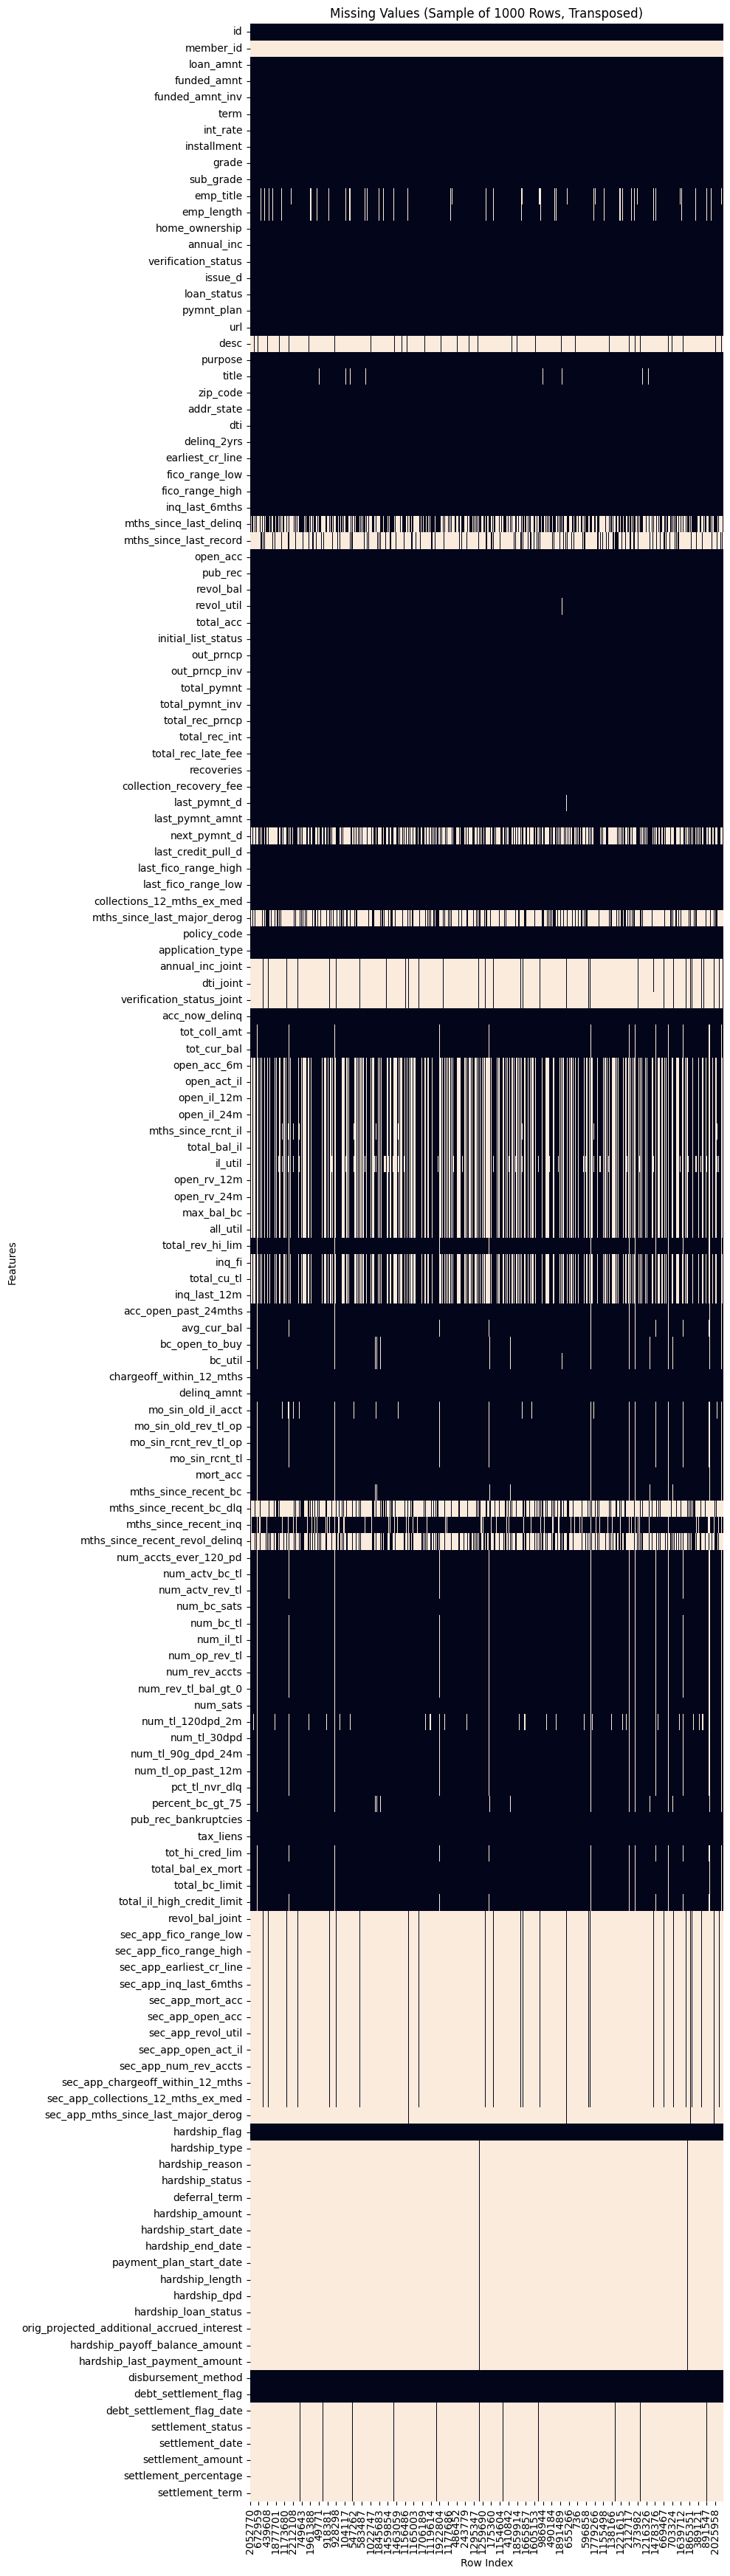

In [9]:
# Missing value overview - sample check
plt.figure(figsize=(10, 35)) 
sns.heatmap(df_raw.sample(5000).isnull().T, cbar=False)
plt.title("Missing Values (Sample of 1000 Rows, Transposed)")
plt.xlabel("Row Index")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [10]:
# Variables with most missing values 
missing = df_raw.isnull().mean().sort_values(ascending=False)
print(missing[missing > 0.5].shape) # missing value% greater than 50%
missing[missing > 0.5]

(44,)


member_id                                    1.0000
orig_projected_additional_accrued_interest   0.9962
hardship_end_date                            0.9952
hardship_start_date                          0.9952
hardship_type                                0.9952
hardship_reason                              0.9952
hardship_status                              0.9952
deferral_term                                0.9952
hardship_last_payment_amount                 0.9952
hardship_payoff_balance_amount               0.9952
hardship_loan_status                         0.9952
hardship_dpd                                 0.9952
hardship_length                              0.9952
payment_plan_start_date                      0.9952
hardship_amount                              0.9952
settlement_term                              0.9849
debt_settlement_flag_date                    0.9849
settlement_status                            0.9849
settlement_date                              0.9849
settlement_a

Observations: 
* Hardship- and settlement- related variables are mostly empty (99% null). **They're post loan data and will have to excluded later**
* Second-applicant related variables contain 95%+ nulls, indicating less than 5% of loans are joint applications **-> Check to confirm**
* Some bureau variables contain more than 50%+ missing values and need to be treated with caution 

In [11]:
# Check application type split 
df_raw['application_type'].value_counts(normalize=True)

application_type
Individual   0.9466
Joint App    0.0534
Name: proportion, dtype: float64

As suspsected, only 5% of the sample are joint applications. 

## 4. Target Variable Analysis
- Distribution of target variable (e.g., `loan_status`)
- Imbalance check

In [12]:
# Distribution of the target variable  
df_raw['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

Note: 'Does not meet the credit policy' is said to be a Lending Club internal flag, indicating loans that were funded but didn't plss LC's internal filters (likely for marketing or strategy reasons). But Since these loans were actually funded and have outcomes, they can be mapped based on the actual performance. 

Value grouping:
* Good (0): 
    * Fully Paid; 
    * Does not meet credit policy. Status: Fully Paid
* Bad (1): 
    * Default; Charged Off; 
    * Does not meet credit policy. Status: Charged Off
* Exclusion (999): 
    * Current 
    * In Grace Period
    * Late (16-30 days)
    * Late (31-120 days)

Create a good-bad flag based on the above mapping.

In [13]:
# Create mapping 
gb_map = {
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0,
    'Charged Off': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Default': 1,
    'Current': 999,
    'In Grace Period': 999,
    'Late (16-30 days)': 999,
    'Late (31-120 days)': 999
}

# Save mapping for reuse
with open("../artifacts/gb_map.json", "w") as f:
    json.dump(gb_map, f)


# GB-FLAG creation function 
def create_gb_flag(df, mapping):
    df['GB_FLAG'] = df['loan_status'].map(mapping)
    df.drop(columns='loan_status', inplace=True)
    return df

# Create GB flag
df_raw = create_gb_flag(df_raw, gb_map)

# Check bad rate
df_raw['GB_FLAG'].value_counts(normalize=True).sort_index()
df_raw[df_raw['GB_FLAG']<=1]['GB_FLAG'].value_counts(normalize=True).sort_index()

GB_FLAG
0.0000     0.4772
1.0000     0.1192
999.0000   0.4037
Name: proportion, dtype: float64

GB_FLAG
0.0000   0.8002
1.0000   0.1998
Name: proportion, dtype: float64

40% of the loans are still ongoing (999); among the complete loans: moderate class imbalance, **80% of good loans, 20% bad**.

Initial model - train without resampling. Check metrics like recall, precision, F1 for the Bad class.
If needed:
* Try class weights (e.g., class_weight='balanced' in Logistic Regression).
* Try resampling techniques like:
    * SMOTE (synthetic data generation for the minority class),
    * Random oversampling,
    * Undersampling the majority class (careful with this—it reduces data).

## 5. Sample Definition

### 5.1 Ongoing Loans

Only keep complete loans.  **<font color='red'> Add reasoning for excluding ongoing loans. </font>**

In [14]:
df = df_raw[df_raw['GB_FLAG'] != 999].copy()

# Check sample size
print("Sample size after removing ongoing loans:", df.shape[0])

Sample size after removing ongoing loans: 1348132


### 5.2 Joint Applications

For this project, we will **set the scope on single-applicant loans** and will drop the joint applications and variables associated with secondary applicants. <br/>  
<font color='red'>**Decision: Drop joint applications and secondary-applicant-related variables**</font>


In [15]:
# Drop joint applications
df = df[df['application_type']=='Individual'].copy()

# Check sample size
print("Sample size after removing joint-applications:", df.shape[0])

Sample size after removing joint-applications: 1322293


In [16]:
# Find features related to the secondary applicant 
sec_app_vars = [col for col in df.columns if 'sec_app' in col or 'joint' in col]
drop_vars = sec_app_vars + ['application_type']

# drop columns related to the secondary applicant and 'application_type'
df.drop(columns=drop_vars, inplace=True)

# Note dropped variables in the feature meta filea

feature_meta.loc[feature_meta['Variable_Name'].isin(drop_vars), 'Drop'] = 1

# Check number of variables left 
print("Number of variables dropped:\n", feature_meta['Drop'].value_counts().sort_index(ascending=False).head(1))
print("Number of variables remained:", df.shape[1])


Number of variables dropped:
 Drop
1    17
Name: count, dtype: int64
Number of variables remained: 134


### 5.3 Sample Period

This dataset spans across more than a decade (2007 - 2018), which is far longer than the development period of a typical scorecard. The sample split decision. will need to be made based on the target deployment date, in this case hypothetically 2019, and time drift.

In [17]:
# Get a yearly/monthly view after removing the current loans 
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df['issue_yr'] = df['issue_d'].dt.year

# Summary of volumes and bad rate
count = df['issue_yr'].value_counts().sort_index()
pct = df['issue_yr'].value_counts(normalize=True).sort_index()*100
bad_rate = df.groupby('issue_yr')['GB_FLAG'].mean()


year_summary = pd.DataFrame({
    "count": count,
    "pct": pct,
    "bad_rate": bad_rate
})

year_summary


,count,pct,bad_rate
issue_yr,,,
2007,603,0.0456,0.2620
2008,2393,0.1810,0.2073
2009,5281,0.3994,0.1369
2010,12537,0.9481,0.1401
2011,21721,1.6427,0.1518
2012,53367,4.0359,0.1620
2013,134804,10.1947,0.1560
2014,223103,16.8724,0.1845
2015,375145,28.3708,0.2018


<Axes: xlabel='issue_yr'>

Text(0.5, 1.0, 'Loan Volume by Year After Removing Current Loans')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Volume')

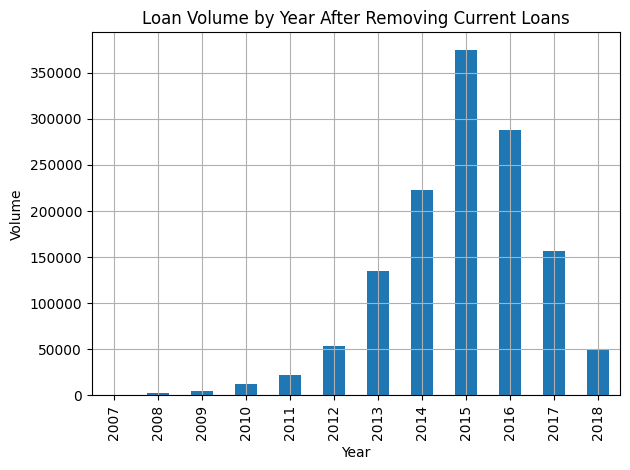

In [18]:
# Visualise yearly loan volume
year_summary['count'].plot(kind='bar')
plt.title("Loan Volume by Year After Removing Current Loans")
plt.xlabel('Year')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()

<Axes: xlabel='issue_yr'>

(0.0, 0.3)

Text(0.5, 1.0, 'Bad Rate by Year After Removing Current Loans')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Volume')

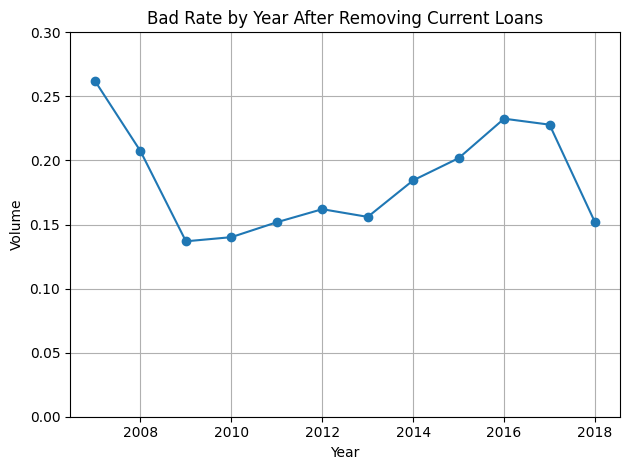

In [19]:
# Visualise bad rate by year
year_summary['bad_rate'].plot(kind='line', marker='o')
plt.ylim(0, 0.3)
plt.title("Bad Rate by Year After Removing Current Loans")
plt.xlabel('Year')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()

**Observations:**
* After removing ongoing loans, loans before 2012 (2007-2011) still only accounts for around **~3%** of total volume.
* Loan volume peaked in 2015 and started to drop afterwards, likely due to loans funded after 2015 with longer loan terms were still ongoing & excluded earlier. 
* In addition, the bad rate fluctuated drastically between 2007 (26.2%) and 2009 (13.7%), likely due to low volume and potentially the impact of GFC.
* Bad rate increased staedily from 2013 to 2016 covering a range of 15.6% to 23.3%

**Decision:**<br/>
With the goal of creating a scorecard for future use (2018 on wards), we will
* Exclude 2007 to 2011 loans (low volume, volatile bad rates)
* Develop the scorecard on **2012-2016 data**
* Test the model on **2017-2018 data**

In [20]:
# Drop loans before 2012
df = df[df['issue_yr'].between(2012, 2018)]

print("Sample size after removing 2007-2011 loans:", df.shape[0])

Sample size after removing 2007-2011 loans: 1279758


### 5.4 Train-Test Split

In [21]:
# Train-test split 
df_train = df[df['issue_yr'].between(2012, 2016)]
df_test = df[df['issue_yr'].isin([2017, 2018])]

print("Train sample size:", df_train.shape[0])
print("Test sample size:", df_test.shape[0])

# Drop issue_yr variable
df_train.drop(columns='issue_yr', inplace=True)
df_test.drop(columns='issue_yr', inplace=True)

Train sample size: 1074238
Test sample size: 205520


## 6. Preliminary Feature Cleaning

### 6.0 Drop Unique Application/ Customer Identifiers
Note that there are two identifier variables `id` and `member_id`. They don't add any useful information and need to be dropped.

<font color='red'>**Drop id and member_id**</font>

In [22]:
# Drop id and member_id 
df_train.drop(columns=['id', 'member_id'], inplace=True)
print("Number of variables remaining:", df_train.shape[1])

# Keep track of dropped variables
drop_vars.extend(['id', 'member_id'])

feature_meta.loc[feature_meta['Variable_Name'].isin(drop_vars), 'Drop'] = 1
feature_meta['Drop'].value_counts()

Number of variables remaining: 132


Drop
0    132
1     19
Name: count, dtype: int64

### 5.1 Leakage Detection

Features that clearly contain post origination info were marked as having leakage and decided to be excluded:
* Decisioning outcome: e.g., `grade`, `sub_grade`
* Loan funding information: e.g., `funded_amnt_inv`, `effective_int_status`
* Loan repayment status: e.g., `total_pymnt`, `total_rec_int`, `out_prncp`, `recoveries`
* Hardship and settlement data: e.g., `hardship_flag`, `hardship_amount`, `settlement_status`, `settlement_amount`

Assumption: assume bureau data was pulled at the time of application and was not updated since therefore no leakage. 

In [23]:
# Leakage classification
feature_meta['Leakage'].value_counts()

Leakage
No       108
Yes       42
Check      1
Name: count, dtype: int64

#### 5.1.1 Features that contain leakage

In [24]:
# Get the list of features that contain leakage 
feature_meta['Variable_Name'] = feature_meta['Variable_Name'].str.strip()
leak_feat = feature_meta.loc[feature_meta['Leakage']=='Yes', 'Variable_Name'].tolist()

print("Numbef of features to drop:", len(leak_feat))
print("Features to drop:", leak_feat)

Numbef of features to drop: 42
Features to drop: ['grade', 'sub_grade', 'funded_amnt_inv', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'last_pymnt_amnt', 'last_pymnt_d', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'pymnt_plan', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'disbursement_method', 'debt_settlement_flag', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term']


<font color='red'>**Drop features with leakage**</font>

In [25]:
# Drop features that contain leakage 
df_train1 = df_train.drop(columns=leak_feat)
print("Number of variables remained:", df_train1.shape[1])

# Track dropped vars
drop_vars.extend(leak_feat)
feature_meta.loc[feature_meta['Variable_Name'].isin(drop_vars), 'Drop'] = 1
feature_meta['Drop'].value_counts()

Number of variables remained: 90


Drop
0    90
1    61
Name: count, dtype: int64

#### 5.1.2 Features with potential leakage

In [26]:
# Check feature that may contain leakage
feature_meta.loc[feature_meta['Leakage']=='Check', 'Variable_Name'].tolist()

['funded_amnt']

In [27]:
# Check funded_amnt against requested amount 
amnt_check = df_train1[['GB_FLAG', 'loan_amnt', 'funded_amnt']]
amnt_check['funded_pctg'] = df_train1['funded_amnt'] / df_train1['loan_amnt'] * 100

# whether funded amount = requested amount
amnt_check['funded_100pct'] = (amnt_check['funded_pctg'] == 100).astype(int)
amnt_check['funded_100pct'].value_counts(normalize=True)

funded_100pct
1   0.9999
0   0.0001
Name: proportion, dtype: float64

In [28]:
# check if there's difference in default rate between funded percentage - not obvious
amnt_check.groupby('funded_100pct')['GB_FLAG'].mean()

funded_100pct
0   0.2769
1   0.1987
Name: GB_FLAG, dtype: float64

Note that `funded_amnt` is a percentage of the requested amount `loan_amnt` up to 100%, indicating that it's an credit decisioning outcome based on the applicant' servicing capability, in other words, containing potential leakage. Also note that 99% of funded amount of approved loans are are equal to the requested amount, rendering it a useless feature essentially. Therefore, we'll drop `funded_amnt`.

<font color='red'>**Drop funded_amnt**</font>

In [29]:
# Drop funded_amnt
df_train1 = df_train1.drop(columns='funded_amnt')

# Keep track of dropped vars
drop_vars.append('funded_amnt')
feature_meta.loc[feature_meta['Variable_Name'].isin(drop_vars), 'Drop'] = 1
feature_meta['Drop'].value_counts()

Drop
0    89
1    62
Name: count, dtype: int64

### 5.2 Review String/Text Features 
These variables are marked as 'check' in the `Keep_Feature_Int` column in the feature meta data sheet.

In [30]:
# Get the list of text and date features
check_feat = feature_meta.loc[feature_meta['Keep_Feature_Int']=='Check', 'Variable_Name'].tolist()
print("Features to check:", check_feat)

Features to check: ['issue_d', 'url', 'title', 'desc', 'funded_amnt', 'emp_title']


**Text variables:**
* `url`: URL for the LC page with listing data --> to be dropped
* `title`: The loan title provided by the borrower
* `desc`: Loan description provided by the borrower
* `emp_title`: The job title supplied by the Borrower when applying for the loan.

In [31]:
# Check Title
print("Number of unique values:", df_train1['title'].nunique())
title_counts = (df_train1['title'].value_counts(normalize=True)*100).round(2)
print(title_counts.head(20))

Number of unique values: 45967
title
Debt consolidation          50.4000
Credit card refinancing     19.4000
Home improvement             5.3400
Other                        4.5700
Major purchase               1.6900
Debt Consolidation           1.2800
Medical expenses             0.9200
Business                     0.8800
Car financing                0.7900
Moving and relocation        0.5600
Vacation                     0.5400
Consolidation                0.4600
debt consolidation           0.4100
Home buying                  0.3400
Debt Consolidation Loan      0.1900
Credit Card Consolidation    0.1900
consolidation                0.1900
Consolidation Loan           0.1400
Personal Loan                0.1300
Home Improvement             0.1300
Name: proportion, dtype: float64


In [32]:
# Desc
print("Number of unique values:", df_train1['desc'].nunique())
desc_counts = (df_train1['desc'].value_counts(normalize=True)*100).round(2)
print(desc_counts.head(20))

Number of unique values: 95440
desc
                                                       0.0300
 Borrower added on 03/17/14 > Debt consolidation<br>   0.0100
 Borrower added on 02/19/14 > Debt consolidation<br>   0.0100
 Borrower added on 03/10/14 > Debt consolidation<br>   0.0100
 Borrower added on 01/29/14 > Debt consolidation<br>   0.0100
 Borrower added on 01/22/14 > Debt consolidation<br>   0.0100
 Borrower added on 01/15/14 > Debt consolidation<br>   0.0100
 Borrower added on 02/26/14 > Debt Consolidation<br>   0.0100
 Borrower added on 01/27/14 > Debt consolidation<br>   0.0100
 Borrower added on 02/03/14 > Debt consolidation<br>   0.0100
 Borrower added on 03/18/14 > Debt consolidation<br>   0.0100
 Borrower added on 01/03/14 > Debt consolidation<br>   0.0100
 Borrower added on 03/05/14 > debt consolidation<br>   0.0100
 Borrower added on 07/25/13 > Debt consolidation<br>   0.0100
 Borrower added on 03/07/14 > Debt consolidation<br>   0.0100
 Borrower added on 03/03/14 > Debt

In [33]:
# emp_title
print("Number of unique values:", df_train1['emp_title'].nunique())
empt_counts = (df_train1['emp_title'].value_counts(normalize=True)*100).round(2)
print(empt_counts.head(20))

Number of unique values: 320141
emp_title
Teacher              1.7100
Manager              1.5200
Owner                0.7800
Registered Nurse     0.7200
RN                   0.6900
Supervisor           0.6600
Sales                0.5800
Driver               0.5500
Project Manager      0.5100
Office Manager       0.4400
General Manager      0.4200
Director             0.4100
manager              0.3800
owner                0.3800
teacher              0.3500
Engineer             0.3500
President            0.3400
driver               0.3000
Vice President       0.2900
Operations Manager   0.2800
Name: proportion, dtype: float64


Based on the above:
* `title` and `desc` are customer input granular details about the loan purpose, which are consolidated into the `purpose` variable available in the dataset. 
* `emp_title` is raw employment information input by the customer as well. While containing useful information, it is messy with variations of spelling and abbreviation for the same job title (380K unique values). 


For a simple model, we'll drop the granular variables. For experimental models in future, we could try processing the text using LLMs and feed the output to the model.

<font color='red'>**Drop url, title, desc, emp_title**</font>

In [34]:
# Drop title, desc and emp_title
df_train2 = df_train1.drop(columns=[ 'url','title', 'desc', 'emp_title'])
print("Number of variables remained:", df_train2.shape[1])

# Check data types after dropping 
df_train2.dtypes.value_counts()

# Keep track of dropped vars
drop_vars.extend([ 'url','title', 'desc', 'emp_title'])
feature_meta.loc[feature_meta['Variable_Name'].isin(drop_vars), 'Drop'] = 1
feature_meta['Drop'].value_counts()

Number of variables remained: 85


float64           75
object             9
datetime64[ns]     1
Name: count, dtype: int64

Drop
0    85
1    66
Name: count, dtype: int64

### 5.3 Value Sanity Checks & Distribution Scans
* Look for:
    * Impossible values (e.g., income = 0, DTI = -1)
    * Implausible values (e.g., income = $10M)
    * Business-illogical values (e.g., number of inquiries = 200)
* Bin or cap if needed
* Optionally create flags

In [35]:
# Split out numeric and categorical variables 
df_train3 = df_train2.copy()

num_cols = df_train3.select_dtypes(include='float64').columns
cat_cols = df_train3.select_dtypes(include='object').columns

print("Number of numeric variables:", len(num_cols))
print("Number of categorical variables:", len(cat_cols))

Number of numeric variables: 75
Number of categorical variables: 9


#### 5.3.1 Categorical Variables

In [36]:
# Check number of unique values in each categorical variables 
for col in cat_cols:
    print(f"{col}:", df_train3[col].nunique())

term: 2
emp_length: 11
home_ownership: 6
verification_status: 3
purpose: 14
zip_code: 939
addr_state: 51
earliest_cr_line: 711
initial_list_status: 2


**Categorical variables with high number of unique values:** 
* `zip_code` (945)
* `earliest_cr_line` (738)

<u>zip_code</u>

In [37]:
# Zip code
print("Top values:", df_train3['zip_code'].value_counts().sort_values(ascending=False).head(10), 
      "\n\nTail values:", df_train3['zip_code'].value_counts().sort_values(ascending=False).tail(10))

Top values: zip_code
945xx    11832
750xx    11594
112xx    11104
606xx    10162
300xx     9718
331xx     9139
070xx     8668
900xx     8588
100xx     8579
770xx     8387
Name: count, dtype: int64 

Tail values: zip_code
093xx    1
987xx    1
516xx    1
511xx    1
522xx    1
643xx    1
340xx    1
552xx    1
698xx    1
525xx    1
Name: count, dtype: int64


Research: 

In the US, the first digit roughly maps to a region:
* 0 = Northeast (e.g., MA, NY)
* 9 = West Coast (e.g., CA, WA)
etc.

3-digit prefixes (like 941, 902, etc.) still partially map to cities or metro areas, so they carry some signal — especially for regional economic factors or fraud. Given that there's `addr_state` in the dataset, there will be overlap between the two variables.

In [38]:
# Check bad rate by state 
state_stats = (
    df_train3.
    groupby('addr_state')['GB_FLAG']
    .agg(n_loans = 'count', bad_rate = 'mean')
    .reset_index()
    .sort_values(by='bad_rate', ascending=False)
)

print("Lowest bad rate state:\n", state_stats[state_stats['bad_rate'] == state_stats['bad_rate'].min()],
     "\n\nHighest bad rate state:\n",  state_stats[state_stats['bad_rate'] == state_stats['bad_rate'].max()])

state_stats.describe(percentiles=[.005, .01, .05, .10, .25, .75, .90, .99])

state_stats.head(20)

Lowest bad rate state:
   addr_state  n_loans  bad_rate
7         DC     2783    0.1330 

Highest bad rate state:
    addr_state  n_loans  bad_rate
12         IA        2    0.5000


,n_loans,bad_rate
count,51.0000,51.0000
mean,21063.4902,0.2007
std,27921.8285,0.0516
min,2.0000,0.1330
0.5%,205.5000,0.1343
1%,409.0000,0.1356
5%,1212.5000,0.1432
10%,2225.0000,0.1569
25%,4499.0000,0.1741
50%,13062.0000,0.1999


,addr_state,n_loans,bad_rate
12,IA,2,0.5000
29,NE,2427,0.2563
25,MS,5200,0.2525
2,AR,8119,0.2396
1,AL,13420,0.2389
36,OK,9863,0.2346
18,LA,12537,0.2301
33,NV,15691,0.2203
34,NY,88308,0.2172
42,TN,16620,0.2149


In [39]:
# Check bad rate by region (first digit of zip code)
df_train3['zip_region'] = df_train3['zip_code'].str[:1]

reg_stats = (
    df_train3.
    groupby('zip_region')['GB_FLAG']
    .agg(n_loans = 'count', bad_rate = 'mean')
    .reset_index()
    .sort_values(by='bad_rate', ascending=False)
)

df_train3.drop(columns ='zip_region', inplace=True)
reg_stats.head(50)

,zip_region,n_loans,bad_rate
1,1,127793,0.2147
3,3,145682,0.2094
4,4,91908,0.2075
7,7,118587,0.2054
2,2,105528,0.1975
0,0,92459,0.1903
5,5,39740,0.1895
8,8,81419,0.1887
6,6,70579,0.1883
9,9,200543,0.1869


In [40]:
# Check bad rate by zip_code
zip_stats = (
    df_train3.
    groupby('zip_code')['GB_FLAG']
    .agg(n_loans = 'count', bad_rate = 'mean')
    .reset_index()
    .sort_values(by='n_loans', ascending=False)
)

zip_stats.describe(percentiles=[.005, .01, .05, .25, .75, .85, .99])

zip_stats.head(50)

,n_loans,bad_rate
count,939.0000,939.0000
mean,1144.0234,0.2075
std,1602.9162,0.1082
min,1.0000,0.0000
0.5%,1.0000,0.0000
1%,1.0000,0.0000
5%,2.0000,0.0833
25%,219.5000,0.1752
50%,542.0000,0.2029
75%,1373.5000,0.2292


,zip_code,n_loans,bad_rate
885,945xx,11832,0.1794
705,750xx,11594,0.1781
103,112xx,11104,0.2188
571,606xx,10162,0.1642
287,300xx,9718,0.1713
318,331xx,9139,0.2304
62,070xx,8668,0.2072
840,900xx,8588,0.1961
91,100xx,8579,0.1712
725,770xx,8387,0.1990


For context, the overall bad rate of the entire dataset is 19.9%. 

* State-level bad rates range from 13.3% (DC, 3462 loans) to 25.9% (MS, 6437 loans).
* By zip-region (first digit of the zip code), the difference is less obvious. Bad rates range from 18.7% (region 8) to 21.5% (region 1), both have ample sample. 
* In region 1 (the overall worst performing), 104xx has 26.2% bad rate and 100xx has 17.6% bad rate (both 10K sample).

Thoughts: 
1. There's sizeable difference across states given the sufficient sample --> **KEEP & AGGREGATE**
2. zip_region is too broad to show patterns -->**DROP**
3. There're pockets of 'bad zone' within each region that can be identified by zip_code --> **CREATE** a flag for high risk zip code and drop the raw zip_code variable. High risk threshold is set such taht:
    * Bad rate > 24%: ~20% higher than the global bad rate of 19.9%;  around 85th percentile of all bad rates across zip codes 
    * Volume ≥ 500: minimizes random noise — a 1% change here reflects 5+ loans

In [41]:
# --------------------- Create a flag for high-risk zip-code -------------------- #
# Identify high risk zip-codes (bad rate > 24% and loan volume > 500)
hi_risk_zip = (
    df_train3
    .groupby('zip_code')
    .agg(bad_rate=('GB_FLAG', 'mean'), n_loans=('GB_FLAG', 'count'))
    .query('bad_rate > 0.24 and n_loans >= 500')
    .index.to_list()
)

# Save high-risk zip-code list to a .json file
with open("../artifacts/hi_risk_zip.json", "w") as f:
    json.dump(hi_risk_zip, f)

# Create a flag for high risk zipcode
def create_hi_risk_zip_flag(df, hi_risk_zip_list, zip_col="zip_code"):
    df = df.copy()
    df['f_hi_risk_zip'] = df[zip_col].isin(hi_risk_zip_list).astype(int)
    df.drop(columns='zip_code', inplace=True)
    return df

df_train3 = create_hi_risk_zip_flag(df_train3, hi_risk_zip)

# Check number of high-risk zip codes 
print("Number of high-risk zip codes:", len(hi_risk_zip))

# Kepp tracked of vars transformation/ dropping
flag_vars=[]
flag_vars.append('zip_code')
feature_meta.loc[feature_meta['Variable_Name'].isin(flag_vars), 'Flag'] = 1
feature_meta.loc[feature_meta['Variable_Name']=='zip_code', 'flag_vars'] = 'f_hi_risk_zip'

Number of high-risk zip codes: 48


In [42]:
#-------------- Group addr_state by risk quatiles -------------- #
def assign_state_risk(bad_rate):
    if bad_rate < 0.175:
        return 'band 1'
    elif bad_rate < 0.19:
        return 'band 2'
    elif bad_rate < 0.20:
        return 'band 3'
    elif bad_rate < 0.212:
        return 'band 4' 
    elif bad_rate < 0.220:
        return 'band 5'
    else:
        return 'band 6'

state_stats['risk_group'] = state_stats['bad_rate'].apply(assign_state_risk)

# Save mapping 
risk_map = dict(zip(state_stats['addr_state'], state_stats['risk_group']))
with open('../artifacts/addr_state_risk_map.json', 'w') as f:
    json.dump(risk_map, f)


# Map it back to the original dataset  
df_train3['addr_state_grouped'] = df_train3['addr_state'].map(risk_map)
df_train3.drop(columns='addr_state', inplace=True)

# Kepp tracked of vars transformation/ dropping
trans_vars = []
trans_vars.append('addr_state')

feature_meta.loc[feature_meta['Variable_Name'].isin(trans_vars), 'Transform'] = 1
feature_meta.loc[feature_meta['Variable_Name']=='addr_state', 'trans_vars'] = 'addr_state_grouped'

<u>earliest_cr_line</u>

In [43]:
# earliest_cr_line
print("Top values:", df_train3['earliest_cr_line'].value_counts().sort_values(ascending=False).head(10), 
      "\n\nTail values:", df_train3['earliest_cr_line'].value_counts().sort_values(ascending=False).tail(10))

Top values: earliest_cr_line
Aug-2001    7932
Aug-2000    7509
Aug-2002    7497
Oct-2001    7377
Sep-2003    7181
Sep-2002    7169
Oct-2000    7114
Aug-2003    6902
Oct-2002    6889
Sep-2000    6789
Name: count, dtype: int64 

Tail values: earliest_cr_line
Feb-1960    1
Feb-1957    1
Dec-1951    1
Nov-1950    1
May-1953    1
Jul-1955    1
Nov-1953    1
Oct-1957    1
Nov-1955    1
Jun-1955    1
Name: count, dtype: int64


Upon examination, `earliest_cr_line` is not categorical, but a date/time variable. 

For it easier to be handled, it will be transformed into 'months since earlierst cr line' by computing the difference between loan `issude_d` and `earliest_cr_line`.

In [44]:
# Convert `earliest_cr_line` to datetime first
df_train3['earliest_cr_line'] = pd.to_datetime(df_train3['earliest_cr_line'])

# Check min/max values 
df_train3[df_train3['earliest_cr_line'] == df_train3['earliest_cr_line'].min()][['earliest_cr_line', 'issue_d']]
df_train3[df_train3['earliest_cr_line'] == df_train3['earliest_cr_line'].max()][['earliest_cr_line', 'issue_d']]

,earliest_cr_line,issue_d
411227,1944-01-01,2015-01-01
1307846,1944-01-01,2014-03-01


,earliest_cr_line,issue_d
2164131,2013-11-01,2016-12-01
2166858,2013-11-01,2016-12-01
2167593,2013-11-01,2016-12-01
2169683,2013-11-01,2016-12-01
2170418,2013-11-01,2016-12-01
2172087,2013-11-01,2016-12-01
2178974,2013-11-01,2016-12-01
2183630,2013-11-01,2016-12-01


In [45]:
# --------------------- Transform earliest_cr_line -------------------- #

def compute_months_since_earliest_cr_line(df):
    # Ensure datetime conversion
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')
    df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')  # in case not yet converted

    # Calculate months difference
    def month_diff(row):
        if pd.isnull(row['earliest_cr_line']) or pd.isnull(row['issue_d']):
            return np.nan
        rd = relativedelta(row['issue_d'], row['earliest_cr_line'])
        return rd.years * 12 + rd.months

    df['mnths_since_earliest_cr_line'] = df.apply(month_diff, axis=1).astype('float64')
    df.drop(columns='earliest_cr_line', inplace=True)
    return df

df_train3 = compute_months_since_earliest_cr_line(df_train3)

In [46]:
# Keep track of vars transformation 
trans_vars.append('earliest_cr_line')

feature_meta.loc[feature_meta['Variable_Name'].isin(trans_vars), 'Transform'] = 1
feature_meta.loc[feature_meta['Variable_Name']=='earliest_cr_line', 'trans_vars'] = 'mnths_since_earliest_cr_line'

<u>Other Categorical Variables</u>

In [47]:
# Check number of unique values in each categorical variables & bad rate

# Excluding `addr_state` as it's been examined 
cat_cols = df_train3.select_dtypes(include='object').columns
cat_cols_excl_state = cat_cols[0:5].tolist() + cat_cols[6:7].tolist()

# Check 
for col in cat_cols_excl_state:
    print(f"\n{col}")
    print(df_train3.groupby(col)['GB_FLAG'].agg(['count', 'mean']).sort_values('mean', ascending=False))


term
            count   mean
term                    
60 months  256176 0.3333
36 months  818062 0.1566

emp_length
             count   mean
emp_length               
1 year       69983 0.2036
< 1 year     83113 0.2030
9 years      42049 0.2019
8 years      52041 0.1997
3 years      84778 0.1984
4 years      62846 0.1971
2 years      96169 0.1964
5 years      66679 0.1958
6 years      50474 0.1945
7 years      49482 0.1944
10+ years   356847 0.1885

home_ownership
                 count   mean
home_ownership               
ANY                 66 0.2424
RENT            429820 0.2293
OWN             113568 0.2046
OTHER               46 0.1957
MORTGAGE        530696 0.1727
NONE                42 0.1667

verification_status
                      count   mean
verification_status               
Verified             344476 0.2337
Source Verified      420054 0.2098
Not Verified         309708 0.1448

purpose
                     count   mean
purpose                          
small_business 

1. Convert variables with only two categories into binary: 
    * `term`: 60-month term loans have almost doubled bad rates than the 36-month loans 
    * `initial_list_status`: no real differences between levels --> **DROP**
2. Convert `emp_length` to ordinal scale (1,2,3,...): the longer the employment length, the lower the bad rate, almost perfectly linear relationship
3. Group 'other', 'any', 'none' into one group in `home_ownership`
4. Keep as is: 
    * `verification_status`: verified (income) loans = lowest bad rate; not verified = highest bad rate
    * `purpose`: range between 12.4% (wedding) to 29.7% (small business)

In [48]:
# ----------- Convert term to binary -----------#
def create_term_flag(df):
    df = df.copy()
    df['f_term_60'] = (df['term'] == ' 60 months').astype(int)
    df.drop(columns='term', inplace=True)
    
    return df 

df_train3 = create_term_flag(df_train3)

# Track change 
flag_vars.append('term')
feature_meta.loc[feature_meta['Variable_Name'].isin(flag_vars), 'Flag'] = 1
feature_meta.loc[feature_meta['Variable_Name']=='term', 'flag_vars'] = 'f_term_60'

In [49]:
# -------------- Drop initial_list_status ----------# 
df_train3.drop(columns='initial_list_status', inplace=True) 
feature_meta.loc[feature_meta['Variable_Name']=='initial_list_status', 'Drop'] = '1'

In [50]:
#----------- Convert emp_length to numeric sacle --------- #

# Create mapping 
emp_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

# Save mapping 
with open("../artifacts/emp_length_map.json", "w") as f:
    json.dump(emp_map, f)

# Define mapping function 
def map_emp_length(df, mapping):
    df['emp_length_num'] = df['emp_length'].map(mapping)
    df.drop(columns='emp_length', inplace=True)
    return df

# Apply mapping 
df_train3 = map_emp_length(df_train3, emp_map)

# Check mapping 
df_train3['emp_length_num'].value_counts()

# Track changes
trans_vars.append('emp_length')
feature_meta.loc[feature_meta['Variable_Name'].isin(trans_vars), 'Transform'] = 1
feature_meta.loc[feature_meta['Variable_Name']=='emp_length', 'trans_vars'] = 'emp_length_num'

emp_length_num
10.0000    356847
2.0000      96169
3.0000      84778
0.0000      83113
1.0000      69983
5.0000      66679
4.0000      62846
8.0000      52041
6.0000      50474
7.0000      49482
9.0000      42049
Name: count, dtype: int64

In [51]:
# --- Group ANY, OTHER, NONE into one group in home_ownership --- #
def group_home_ownership(df, col='home_ownership', new_col='home_ownership_grouped'):
    def other_group(x):
        return 'Other' if x in ['ANY', 'NONE', 'OTHER'] else x
    
    df[new_col] = df[col].apply(other_group)
    df.drop(columns=col, inplace=True)
    return df

df_train3 = group_home_ownership(df_train3)

# Track changes
trans_vars.append('home_ownership')
feature_meta.loc[feature_meta['Variable_Name']=='home_ownership', 'Transform'] = 1
feature_meta.loc[feature_meta['Variable_Name']=='home_ownership', 'trans_vars'] = 'home_ownership_grouped'

df_train3['home_ownership_grouped'].value_counts()


home_ownership_grouped
MORTGAGE    530696
RENT        429820
OWN         113568
Other          154
Name: count, dtype: int64

In [52]:
feature_meta.loc[feature_meta['Variable_Name']=='home_ownership', 'Transform'] = 1

In [53]:
# Rerun variable list by type
num_cols = df_train3.select_dtypes(include='float64').columns
print("Number of numeric variables:", len(num_cols))

Number of numeric variables: 77


In [54]:
# Descriptive stats
summary = df_train3[num_cols].describe(percentiles=[.005, .01, .05, .25, .75, .95, .99, .995]).T

#  Create checking flags

# Rule 1 - negative minimum value
summary['f_neg_min'] = (summary['min'] < 0).astype(int)

# Rule 2 - extremely large value/ outliers
summary['max_over_q99'] = summary['max'] / summary['99%']

# Rule 3 - skewed distributions
summary['skew'] = df_train3[num_cols].skew()
summary['f_skew'] = (summary['skew'].abs() > 5).astype(int)

Add variable type informaiton from the feature meta file for checking by category 

In [55]:
summary = summary.reset_index()

# Stripping leading / trailing white space
summary['index'] = summary['index'].str.strip()
feature_meta['Variable_Name'] = feature_meta['Variable_Name'].str.strip()

# Join feature_meata able 
summary2 = summary.merge(feature_meta[['Variable_Name', 'Variable_Type']], 
                         how='left',
                         left_on='index',
                         right_on='Variable_Name')

# Drop redundant column in the joined table
summary2.drop(columns='Variable_Name', inplace=True)

# Check missing in the joined columns
print("Features without meta data:\n", summary2[summary2['Variable_Type'].isna()]['index'])

Features without meta data:
 74                         GB_FLAG
75    mnths_since_earliest_cr_line
76                  emp_length_num
Name: index, dtype: object


In [56]:
# Drop emp_length_num which has been examined before conversion
summary2.drop(75, inplace=True)

# Add variable type for mnths_since_earliest_cr_line manually
summary2['Variable_Type'] = summary2['Variable_Type'].fillna('Bureau - Months, earliest')

summary2['Variable_Type'].value_counts().sort_index()

Variable_Type
Applicant                                  2
Application                                2
Bureau - Amount, Balance                   6
Bureau - Amount, Delq                      2
Bureau - Amount, Limit                     6
Bureau - Months, earliest                  4
Bureau - Months, recent                   10
Bureau - Number, Accounts                  9
Bureau - Number, Accounts, Active/Open     5
Bureau - Number, Accounts, Delq            6
Bureau - Number, Accounts, L12M            3
Bureau - Number, Accounts, L24M            3
Bureau - Number, Accounts, L6M             1
Bureau - Number, Delq                      6
Bureau - Number, Inquiry                   3
Bureau - Score                             2
Bureau - Utility Rate                      4
Loan Funding                               2
Name: count, dtype: int64

##### A. Negative Min Values

In [57]:
# Find variables with negative min
summary2[summary2['f_neg_min']==1]

,index,count,mean,std,min,0.5%,1%,5%,25%,50%,75%,95%,99%,99.5%,max,f_neg_min,max_over_q99,skew,f_skew,Variable_Type
4,dti,1074238.0000,18.3042,8.3682,-1.0000,1.3300,2.1200,5.3000,12.0200,17.8000,24.2100,32.8800,37.7700,38.9800,49.9600,1,1.3227,0.2439,0,Applicant


In [58]:
# Check counts of negative values 
print("Number of negative values:", df_train3[df_train3['dti']<0].shape[0])

# Check missing values 
print("Number of missing values:", df_train3['dti'].isnull().sum())

Number of negative values: 1
Number of missing values: 0


There's only one variable `dti` with negative values (-1), which only occured once. The -1 is like a place holder for missing value and can be kept this way.

##### B. Extreme Large Values/ Outliers

In [59]:
# Get a list of variables with max value > 2 times 99% percentile
outliers = summary2[summary2['max_over_q99']>2].sort_values('max_over_q99', ascending=False)
print("Number of variables with potential outliers:", outliers.shape[0])

outliers['Variable_Type'].value_counts().sort_index()

Number of variables with potential outliers: 60


Variable_Type
Applicant                                 1
Bureau - Amount, Balance                  6
Bureau - Amount, Delq                     2
Bureau - Amount, Limit                    5
Bureau - Months, earliest                 1
Bureau - Months, recent                   8
Bureau - Number, Accounts                 9
Bureau - Number, Accounts, Active/Open    5
Bureau - Number, Accounts, Delq           6
Bureau - Number, Accounts, L12M           3
Bureau - Number, Accounts, L24M           3
Bureau - Number, Accounts, L6M            1
Bureau - Number, Delq                     5
Bureau - Number, Inquiry                  2
Bureau - Utility Rate                     3
Name: count, dtype: int64

Check outliers by variable type

**Months (since recent/ earliest) - 13 Variables**

In [60]:
mo_vars = summary2[summary2['Variable_Type'].str.contains('Months')]
mo_vars['max_yr'] = (mo_vars['max'] / 12).round(0)
mo_vars['q99_yr'] = (mo_vars['99%'] / 12).round(0)

print("Number of 'month' variables:", mo_vars.shape[0])
mo_vars.sort_values(by=['Variable_Type', 'max_over_q99'], ascending=False)

Number of 'month' variables: 14


,index,count,mean,std,min,0.5%,1%,5%,25%,50%,75%,95%,99%,99.5%,max,f_neg_min,max_over_q99,skew,f_skew,Variable_Type,max_yr,q99_yr
46,mo_sin_rcnt_tl,1046497.0000,7.9326,8.8752,0.0000,0.0000,0.0000,1.0000,3.0000,5.0000,10.0000,23.0000,44.0000,57.0000,314.0000,0,7.1364,4.3584,0,"Bureau - Months, recent",26.0000,4.0000
45,mo_sin_rcnt_rev_tl_op,1046496.0000,13.1054,16.3063,0.0000,0.0000,0.0000,1.0000,4.0000,8.0000,16.0000,44.0000,85.0000,98.0000,438.0000,0,5.1529,3.4088,0,"Bureau - Months, recent",36.0000,7.0000
48,mths_since_recent_bc,1056876.0000,24.0554,30.6848,0.0000,0.0000,1.0000,2.0000,6.0000,13.0000,29.0000,87.0000,143.0000,173.0000,639.0000,0,4.4685,3.3455,0,"Bureau - Months, recent",53.0000,12.0000
26,mths_since_rcnt_il,298704.0000,20.2162,25.7778,0.0000,1.0000,1.0000,2.0000,6.0000,12.0000,22.0000,74.0000,130.0000,148.0000,511.0000,0,3.9308,3.3320,0,"Bureau - Months, recent",43.0000,11.0000
51,mths_since_recent_revol_delinq,374164.0000,35.7935,22.4487,0.0000,1.0000,2.0000,5.0000,17.0000,33.0000,52.0000,76.0000,81.0000,83.0000,197.0000,0,2.4321,0.4274,0,"Bureau - Months, recent",16.0000,7.0000
17,mths_since_last_major_derog,291632.0000,43.4720,21.3074,0.0000,2.0000,3.0000,9.0000,26.0000,43.0000,61.0000,76.0000,82.0000,87.0000,197.0000,0,2.4024,0.0484,0,"Bureau - Months, recent",16.0000,7.0000
9,mths_since_last_delinq,539320.0000,34.1198,21.8997,0.0000,1.0000,1.0000,5.0000,15.0000,31.0000,50.0000,74.0000,80.0000,81.0000,192.0000,0,2.4000,0.4607,0,"Bureau - Months, recent",16.0000,7.0000
49,mths_since_recent_bc_dlq,266398.0000,39.7981,22.7389,0.0000,1.0000,2.0000,6.0000,21.0000,38.0000,59.0000,77.0000,82.0000,86.0000,189.0000,0,2.3049,0.2181,0,"Bureau - Months, recent",16.0000,7.0000
50,mths_since_recent_inq,960405.0000,6.7514,5.8805,0.0000,0.0000,0.0000,0.0000,2.0000,5.0000,10.0000,19.0000,23.0000,23.0000,25.0000,0,1.0870,0.9533,0,"Bureau - Months, recent",2.0000,2.0000
10,mths_since_last_record,183248.0000,69.6978,26.4716,0.0000,6.0000,9.0000,24.0000,52.0000,70.0000,89.0000,113.0000,118.0000,118.0000,121.0000,0,1.0254,-0.1565,0,"Bureau - Months, recent",10.0000,10.0000


As checked before, the minimum value in the raw `earliest_cr_line` in the training set is Jan-1944; the `issue_d` of that loan is March-2014, which is in fact 71 years in between.<br> 
If this person opened their first credit product in 1944 at the age of 18, they would be 88 years old by the time they got approve for this loan, which is highly unlikely. It's likely that for some legacy credit reports, default or corrupted date values were used (e.g., date recorded as 1934 due to format/parsing issues or missing DOB checks).

If we take a step back and trust this record is correct and the credit bureau does have 70 years of history, it is technically possible for the most recent delinquency or account opening to be 36 (`mths_since_recent_revol_delinq`) to 53 (`mths_since_recent_bc`) years ago, bute more likely to be data defect. 

To avoid data defect / outliers skewing the model, <font color='red'><b>the following cap will be appplied:</b></font>
* Months since earliest: 600 months (or 50 years)
* Months since recent: 180 months (or 15 years)

In [61]:
feature_meta.columns

Index(['Variable_Name', 'Description', 'Variable_Type', 'Leakage',
       'Keep_Feature_Int', 'Reason', 'Drop', 'Flag', 'flag_vars', 'Transform',
       'trans_vars', 'Cap', 'cap_flags', 'cap_val_lower', 'cap_val_upper',
       'miss_flags', 'miss_impute_val'],
      dtype='object')

In [62]:
# ----------------------- Capping Months Since ----------------#
# set threshold
cap_recent = 180
cap_old = 600


# Identify variable groups
old_vars = mo_vars[mo_vars['Variable_Type'].str.contains("earliest")]['index']
recent_vars = mo_vars[mo_vars['Variable_Type'].str.contains("recent")]['index']

# Create a flag for capped records 
capped_recent = df_train3[recent_vars].gt(cap_recent).any(axis=1)
capped_old = df_train3[old_vars].gt(cap_old).any(axis=1)
df_train3['F_CAPPED_MNTHS'] = (capped_recent | capped_old).astype(int)

# Apply the cap
for var in recent_vars:
    df_train3[var] = df_train3[var].clip(upper=cap_recent)  

for var in old_vars: 
    df_train3[var] = df_train3[var].clip(upper=cap_old) 

# Keep track of capped / flagged variables
cap_vars = old_vars.tolist() + recent_vars.tolist()
feature_meta.loc[feature_meta['Variable_Name'].isin(cap_vars), 'Cap'] = 1
feature_meta.loc[feature_meta['Variable_Name'].isin(cap_vars), 'cap_flags'] = 'F_CAPPED_MNTHS'
feature_meta.loc[feature_meta['Variable_Name'].isin(old_vars), 'cap_val_upper'] = cap_old
feature_meta.loc[feature_meta['Variable_Name'].isin(recent_vars), 'cap_val_upper'] = cap_recent

# Check what % of records were capped:
for var in recent_vars:
    cap_count = (df_train3[var] == 180).sum()
    print(f"{var}: {cap_count} records capped ({cap_count / len(df) * 100:.2f}%)")

for var in old_vars:
    cap_count = (df_train3[var] == 600).sum()
    print(f"{var}: {cap_count} records capped ({cap_count / len(df) * 100:.2f}%)")

df_train3['F_CAPPED_MNTHS'].value_counts()

mths_since_last_delinq: 4 records capped (0.00%)
mths_since_last_record: 0 records capped (0.00%)
mths_since_last_major_derog: 5 records capped (0.00%)
mths_since_rcnt_il: 422 records capped (0.03%)
mo_sin_rcnt_rev_tl_op: 204 records capped (0.02%)
mo_sin_rcnt_tl: 19 records capped (0.00%)
mths_since_recent_bc: 4464 records capped (0.35%)
mths_since_recent_bc_dlq: 2 records capped (0.00%)
mths_since_recent_inq: 0 records capped (0.00%)
mths_since_recent_revol_delinq: 3 records capped (0.00%)
mo_sin_old_il_acct: 6 records capped (0.00%)
mo_sin_old_rev_tl_op: 890 records capped (0.07%)
GB_FLAG: 0 records capped (0.00%)
emp_length_num: 0 records capped (0.00%)


F_CAPPED_MNTHS
0    1068588
1       5650
Name: count, dtype: int64

**Number of Accounts - 27 Variables**

In [63]:
num_accts = summary2[summary2['Variable_Type'].str.contains('Number, Accounts')].sort_values(by=['Variable_Type', 'max'], ascending=False)

print("Number of accounts variables:", num_accts.shape[0])
num_accts

Number of accounts variables: 27


,index,count,mean,std,min,0.5%,1%,5%,25%,50%,75%,95%,99%,99.5%,max,f_neg_min,max_over_q99,skew,f_skew,Variable_Type
22,open_acc_6m,306584.0000,1.0685,1.2239,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,3.0000,5.0000,6.0000,18.0000,0,3.6000,1.6343,0,"Bureau - Number, Accounts, L6M"
37,acc_open_past_24mths,1066743.0000,4.6146,3.1337,0.0000,0.0000,0.0000,1.0000,2.0000,4.0000,6.0000,10.0000,14.0000,16.0000,64.0000,0,4.5714,1.3557,0,"Bureau - Number, Accounts, L24M"
30,open_rv_24m,306585.0000,3.0401,2.6929,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,4.0000,8.0000,12.0000,14.0000,53.0000,0,4.4167,1.8742,0,"Bureau - Number, Accounts, L24M"
25,open_il_24m,306585.0000,1.7235,1.7121,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,2.0000,5.0000,8.0000,9.0000,51.0000,0,6.3750,1.9702,0,"Bureau - Number, Accounts, L24M"
65,num_tl_op_past_12m,1046497.0000,2.1479,1.8154,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,3.0000,5.0000,8.0000,9.0000,32.0000,0,4.0000,1.5089,0,"Bureau - Number, Accounts, L12M"
29,open_rv_12m,306585.0000,1.4407,1.5771,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,4.0000,7.0000,8.0000,28.0000,0,4.0000,1.9616,0,"Bureau - Number, Accounts, L12M"
24,open_il_12m,306585.0000,0.7839,1.0158,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,3.0000,4.0000,5.0000,25.0000,0,6.2500,1.9291,0,"Bureau - Number, Accounts, L12M"
52,num_accts_ever_120_pd,1046497.0000,0.5048,1.2996,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,6.0000,8.0000,51.0000,0,8.5000,4.8955,0,"Bureau - Number, Accounts, Delq"
5,delinq_2yrs,1074238.0000,0.3279,0.8902,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,4.0000,5.0000,39.0000,0,9.7500,5.4620,1,"Bureau - Number, Accounts, Delq"
64,num_tl_90g_dpd_24m,1046497.0000,0.0904,0.5037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,3.0000,39.0000,0,19.5000,12.9509,1,"Bureau - Number, Accounts, Delq"


First,  note that there're three 'account number' type variables whose 99th percentile is 0 and maximum is a large-ish positive number, i.e., the data is heavily skewed: `acc_now_delinq` (max=14), `num_tl_120dpd_2m` (max=6), `num_tl_30dpd` (max=4).

Check value distribution of these three variables first to see if it's appropriate to convert them into binary flags.

In [64]:
df_train3['acc_now_delinq'].value_counts()
df_train3['num_tl_120dpd_2m'].value_counts()
df_train3['num_tl_30dpd'].value_counts()

acc_now_delinq
0.0000     1068689
1.0000        5223
2.0000         274
3.0000          37
4.0000          10
5.0000           3
6.0000           1
14.0000          1
Name: count, dtype: int64

num_tl_120dpd_2m
0.0000    1005946
1.0000        785
2.0000         28
3.0000          3
6.0000          1
4.0000          1
Name: count, dtype: int64

num_tl_30dpd
0.0000    1042885
1.0000       3410
2.0000        170
3.0000         25
4.0000          7
Name: count, dtype: int64

`acc_now_delinq` has the most unique values (7) with 94% of non-zero values being 1. The other two values have 4-5 values, but similar distribution: 1 accounts for 90%+. 

It is appropriate to convert these numeric variables into binary flag to simply capture the default behaviour regardless how many accounts are in delinequency.

<font color='red'>**Convert rare-event delinquency counts variable into binary falgs**</font>

In [65]:
dlq_flag_vars = outliers[(outliers['Variable_Type'].str.contains('Number, Accounts')) & (outliers['99%']==0)]['index']

# define a function to create flags for non-zero values 
def create_gt0_flag(df, var_list):
    for var in var_list:
        df[f'f_{var}_gt0'] = (df[var]>0).astype(int)
        df.drop(columns=var, inplace=True)
    return df

# apply the function 
df_train3 = create_gt0_flag(df_train3, dlq_flag_vars)

# track changes 
for var in dlq_flag_vars:
    feature_meta.loc[feature_meta['Variable_Name']==var, 'flag_vars'] = f'f_{var}_gt0'
    print(df_train3[f'f_{var}_gt0'].value_counts())

flag_vars.extend(dlq_flag_vars)
feature_meta.loc[feature_meta['Variable_Name'].isin(dlq_flag_vars), 'Flag'] = 1

f_acc_now_delinq_gt0
0    1068689
1       5549
Name: count, dtype: int64
f_num_tl_120dpd_2m_gt0
0    1073420
1        818
Name: count, dtype: int64
f_num_tl_30dpd_gt0
0    1070626
1       3612
Name: count, dtype: int64


The rest of variables fall into four categories: 
1. total number of accounts, 
2. number of open/active accounts, 
3. number of accounts opened in L12M/L24M, 
4. number of delinquent accounts

The value of category 2-4 shouldn't exceed the value of variable in category 1 for each respective category (bankcards, instalment accounts etc.). However, the max values in category 1 is very large. For example, `total_acc`: 176, `num_il_tl`: 159, `num_rev_accounts`: 126, `mort_acc`: 51. Max over 99 percentile ratio varies from 3 to 6. And this could be due to a few reasons:
* Closed accounts still show up, and sometimes stay for years
* Retail finance accounts (e.g., Afterpay, store cards) pad the count
* Authorized user accounts may be reported even if the person isn't the owner
* Mature borrowers can genuinely have 50+ accounts</br>

So a raw value of 176 can exist, but likely isn't representative for modeling. To reduce the effect of extreme values while preserving legitimate variation, we applied a cap at **1.5× the 99th percentile**. This rule was chosen to strike a balance between retaining high-value customers and limiting the distortion of rare anomalies that would otherwise skew binning and model estimation. The multiplier was tested for various variables and found to maintain stable binning performance and logical WOE patterns.

<font color='red'>**Capping number of accounts at 1.5 x 99th percentile**</font>

In [66]:
# List of variables to apply capping 
acct_cap_vars = outliers[(outliers['Variable_Type'].str.contains('Number, Accounts')) & (outliers['99%']>0)]['index']

# Compute the 99th percentiles
q99 = df_train3[acct_cap_vars].quantile(0.99)
caps = round(q99 * 1.5)

# Check cap values
caps

num_tl_90g_dpd_24m       3.0000
delinq_2yrs              6.0000
num_accts_ever_120_pd    9.0000
open_il_24m             12.0000
mort_acc                12.0000
open_il_12m              6.0000
total_cu_tl             20.0000
acc_open_past_24mths    21.0000
num_il_tl               52.0000
num_bc_sats             21.0000
open_rv_24m             18.0000
open_rv_12m             10.0000
num_tl_op_past_12m      12.0000
num_op_rev_tl           34.0000
open_acc_6m              8.0000
num_actv_bc_tl          16.0000
open_acc                44.0000
num_sats                44.0000
num_actv_rev_tl         26.0000
open_act_il             24.0000
num_bc_tl               36.0000
total_acc               92.0000
num_rev_tl_bal_gt_0     24.0000
num_rev_accts           62.0000
Name: 0.99, dtype: float64

The 1.5*q99 value for the common variables are:
* `mort_acc`(number of mortgage accounts): 12
* `open_acc`(number of open accounts): 44
* `num_rev_accts` (number of revolving accounts): 62

The cap values are in line with domain knowledge, confirming the choice of capping scaler.

In [67]:
# Track capped/flagged variables in feature_meta
cap_vars.extend(acct_cap_vars)

for var, cap_val in caps.items():
    feature_meta.loc[feature_meta['Variable_Name'] == var, 'Cap'] = 1
    feature_meta.loc[feature_meta['Variable_Name'] == var, 'cap_val_upper'] = cap_val

feature_meta.loc[feature_meta['Variable_Name'].isin(acct_cap_vars), 'cap_flags'] = 'F_CAPPED_NUMACCTS'

# Build cap var-val dictionary from feature 
cap_dict = feature_meta[feature_meta['cap_flags'] == 'F_CAPPED_NUMACCTS'].set_index('Variable_Name')['cap_val_upper'].to_dict()
acct_cap_vars = list(cap_dict.keys())

# Flag capped variables 
df_train3['F_CAPPED_NUMACCTS'] = df_train3[acct_cap_vars].gt(pd.Series(cap_dict)).any(axis=1).astype(int)
df_train3['F_CAPPED_NUMACCTS'].value_counts()

# Apply capping
for var in acct_cap_vars:
    df_train3[var] = df_train3[var].clip(upper=cap_dict[var])

# Check what % of records were capped:
for var in acct_cap_vars:
    cap_count = (df_train3[var] == caps[var]).sum()
    print(f"{var}: {cap_count} records capped ({cap_count / len(df) * 100:.2f}%)")


F_CAPPED_NUMACCTS
0    1059466
1      14772
Name: count, dtype: int64

total_acc: 305 records capped (0.02%)
num_bc_tl: 611 records capped (0.05%)
num_sats: 477 records capped (0.04%)
num_bc_sats: 1710 records capped (0.13%)
num_il_tl: 1214 records capped (0.09%)
num_rev_accts: 454 records capped (0.04%)
num_rev_tl_bal_gt_0: 918 records capped (0.07%)
mort_acc: 1569 records capped (0.12%)
total_cu_tl: 624 records capped (0.05%)
open_acc: 498 records capped (0.04%)
num_actv_bc_tl: 1184 records capped (0.09%)
num_actv_rev_tl: 710 records capped (0.06%)
open_act_il: 381 records capped (0.03%)
num_op_rev_tl: 867 records capped (0.07%)
open_acc_6m: 381 records capped (0.03%)
num_tl_op_past_12m: 1692 records capped (0.13%)
open_il_12m: 876 records capped (0.07%)
open_rv_12m: 712 records capped (0.06%)
acc_open_past_24mths: 1472 records capped (0.12%)
open_il_24m: 411 records capped (0.03%)
open_rv_24m: 520 records capped (0.04%)
num_tl_90g_dpd_24m: 6241 records capped (0.49%)
delinq_2yrs: 4840 records capped (0.38%)
num_accts_ever_120_pd: 3987 records capped (0

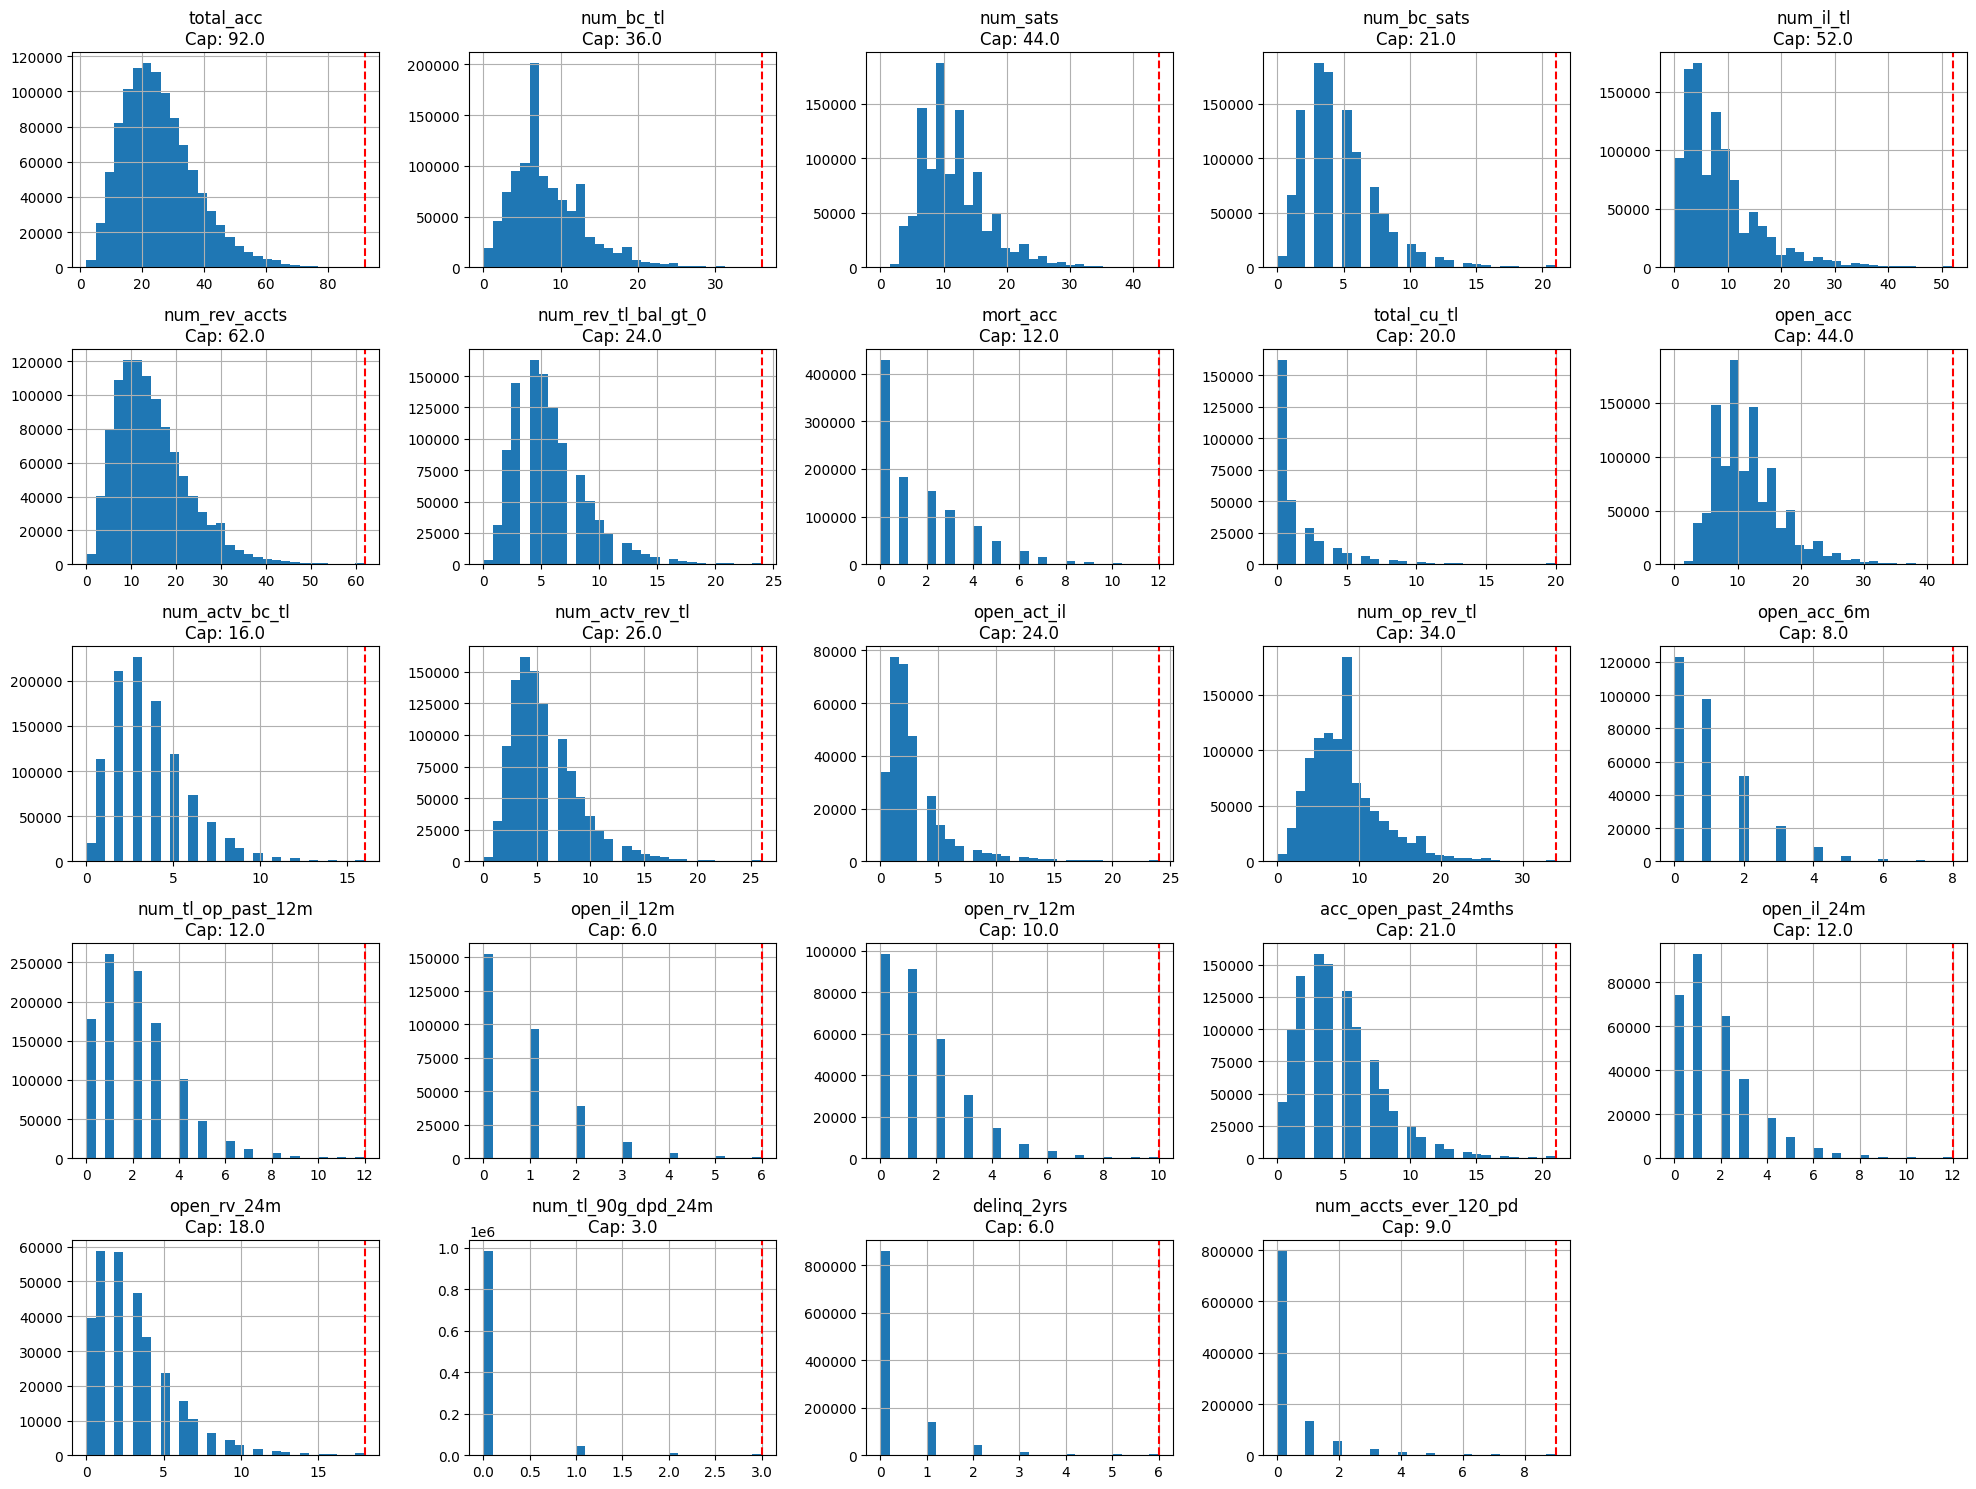

In [68]:
# Check capping effect 
def batch_plot_cap_effect(df, capped_vars_dict):
    n = len(capped_vars_dict)
    n_cols = 5
    n_rows = (n // n_cols) + int(n % n_cols != 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
    axes = axes.flatten()

    for i, (var, cap_val) in enumerate(capped_vars_dict.items()):
        ax = axes[i]
        df[var].hist(bins=30, ax=ax)
        ax.axvline(x=cap_val, color='red', linestyle='--')
        ax.set_title(f"{var}\nCap: {cap_val}")

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
 
    plt.tight_layout()
    plt.show()

batch_plot_cap_effect(df_train3, cap_dict)

**Number of Inquireis - 3 Variables**

In [69]:
summary2[summary2['Variable_Type'].str.contains('Inq')].sort_values(by=['Variable_Type', 'max'], ascending=False)

,index,count,mean,std,min,0.5%,1%,5%,25%,50%,75%,95%,99%,99.5%,max,f_neg_min,max_over_q99,skew,f_skew,Variable_Type
36,inq_last_12m,306584.0000,2.2960,2.5430,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,3.0000,7.0000,12.0000,14.0000,49.0000,0,4.0833,2.2782,0,"Bureau - Number, Inquiry"
34,inq_fi,306585.0000,1.0220,1.5533,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,4.0000,7.0000,8.0000,48.0000,0,6.8571,2.7818,0,"Bureau - Number, Inquiry"
8,inq_last_6mths,1074237.0000,0.6640,0.9495,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,3.0000,4.0000,4.0000,8.0000,0,2.0000,1.7011,0,"Bureau - Number, Inquiry"


Observations:
* The max values for `inq_last_12m` (49) and `inq_fi` (48) are not extreme  - this is likely just rare behavior, rather than data error
* `inq_last_6mths` maximum values is even more reasonable 
* All three variables' skews < 3, so not overly distorted.

These variables tend to have monotonic relationships with bad rate (i.e., more inquiries = higher risk), so we want to preserve their tails rather than cap them -> <font color='blue'>**KEEP AS IS FOR NOW**</font>

At later stage:
* Consider binning based on bad rate lift if needed (e.g., 0, 1–2, 3–4, 5+)
* Or keep as-is if later uses tree-based models

**Number of Delinquency - 5 Variables**

In [70]:
num_delq = outliers[outliers['Variable_Type'].str.contains('Number, Delq')].sort_values(by=['Variable_Type', 'max'], ascending=False)
num_delq

,index,count,mean,std,min,0.5%,1%,5%,25%,50%,75%,95%,99%,99.5%,max,f_neg_min,max_over_q99,skew,f_skew,Variable_Type
12,pub_rec,1074238.0000,0.2199,0.6192,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,3.0000,3.0000,86.0000,0,28.6667,12.3816,1,"Bureau - Number, Delq"
69,tax_liens,1074238.0000,0.0554,0.4161,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,2.0000,85.0000,0,42.5000,33.9970,1,"Bureau - Number, Delq"
16,collections_12_mths_ex_med,1074238.0000,0.0169,0.1462,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,20.0000,0,20.0000,15.6290,1,"Bureau - Number, Delq"
68,pub_rec_bankruptcies,1074238.0000,0.1331,0.3802,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,2.0000,12.0000,0,12.0000,3.5830,0,"Bureau - Number, Delq"
41,chargeoff_within_12_mths,1074238.0000,0.0094,0.1111,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,10.0000,0,inf,17.2701,1,"Bureau - Number, Delq"


In [71]:
# Check value distribution
delq_vars = num_delq['index']

for var in delq_vars:
    print(df_train3[var].nunique(),"\n",df_train3[var].value_counts().sort_index().head(10),"\n")

37 
 pub_rec
0.0000    890990
1.0000    151518
2.0000     20882
3.0000      6328
4.0000      2257
5.0000      1087
6.0000       544
7.0000       238
8.0000       143
9.0000        68
Name: count, dtype: int64 

36 
 tax_liens
0.0000    1037650
1.0000      24925
2.0000       6800
3.0000       2428
4.0000       1118
5.0000        588
6.0000        303
7.0000        151
8.0000         79
9.0000         51
Name: count, dtype: int64 

15 
 collections_12_mths_ex_med
0.0000    1057705
1.0000      15321
2.0000       1016
3.0000        120
4.0000         44
5.0000         14
6.0000          7
7.0000          3
8.0000          1
9.0000          1
Name: count, dtype: int64 

12 
 pub_rec_bankruptcies
0.0000    942697
1.0000    122897
2.0000      6698
3.0000      1400
4.0000       351
5.0000       127
6.0000        39
7.0000        15
8.0000         9
9.0000         3
Name: count, dtype: int64 

10 
 chargeoff_within_12_mths
0.0000     1065303
1.0000        8109
2.0000         655
3.0000         

Observations:
* `tax_liens`: max = 85, 99th percentile = 2, extremely skewed (skew=33), 36 unique values. 96% of the values are 0, 1 only accounts for 67% of non-zero values. 
* `pub_rec`: max = 86, 99th percentile = 2, highly skewed (skew=12), 37 unique values. 83% of the values are 9, 1 accounts for 83% of non-zero values. 
* `pub_rec_bankruptcies`: max = 12, 99th percentile = 1, skew=3.5. 12 unique values, 87% are 0, 1 accounts for 93% of non-zero values.
* `collections_12_mths_ex_med`: extremely skewed (skew=16). 98% of the values are 0, 1 accounts for 91% of non-zero values.
* `chargeoff_within_12_mths`: extremely skewed (skew=18), 99% of the values are 0.

<font color='red'>**Two treaments based on the distribution:**</font>
1. Binary flags: collections_12_mths_ex_med and chargeoff_within_12_mths
2. Capping: tax_liens , pub_rec, and pub_rec_bankruptcies


In [72]:
# ----------------- Convert collection/ chargeoff variables in to binary flags ------------------- #
coll_flag_vars = ['collections_12_mths_ex_med', 'chargeoff_within_12_mths']

for var in coll_flag_vars:
    df_train3[f'f_{var}_gt0'] = (df_train3[var] > 0).astype(int)
    feature_meta.loc[feature_meta['Variable_Name']==var, 'flag_vars'] = f'f_{var}_gt0'
    print(df_train3[f'f_{var}_gt0'].value_counts())

# Track flagged vars
flag_vars.extend(coll_flag_vars)
feature_meta.loc[feature_meta['Variable_Name'].isin(coll_flag_vars), 'Flag'] = 1

# drop raw variables 
df_train3.drop(columns=coll_flag_vars, inplace=True)

f_collections_12_mths_ex_med_gt0
0    1057705
1      16533
Name: count, dtype: int64
f_chargeoff_within_12_mths_gt0
0    1065303
1       8935
Name: count, dtype: int64


In [73]:
# Create cap-value dictionary
taxrec_vars = ['pub_rec', 'tax_liens', 'pub_rec_bankruptcies']
taxrec_caps = [5, 4, 3]
taxrec_cap_dict = dict(zip(taxrec_vars, taxrec_caps))

# Track cap-value and flags in feature_meta
for var, cap_val in taxrec_cap_dict.items():
    feature_meta.loc[feature_meta['Variable_Name'] == var, 'Cap'] = 1
    feature_meta.loc[feature_meta['Variable_Name'] == var, 'cap_val_upper'] = cap_val

feature_meta.loc[feature_meta['Variable_Name'].isin(taxrec_vars), 'cap_flags'] = 'F_CAPPED_DELQ'

In [74]:
# -------------- Apply Capping: tax liens & public records --------------#

# Build cap var-val dictionary from feature 
taxrec_cap_dict = feature_meta[feature_meta['cap_flags'] == 'F_CAPPED_DELQ'].set_index('Variable_Name')['cap_val_upper'].to_dict()
taxrec_vars = list(taxrec_cap_dict.keys())

# Flag capped variables 
df_train3['F_CAPPED_DELQ'] = df_train3[taxrec_vars].gt(pd.Series(taxrec_cap_dict)).any(axis=1).astype(int)
df_train3['F_CAPPED_DELQ'].value_counts()

# Apply capping
for var in taxrec_vars:
    df_train3[var] = df_train3[var].clip(upper=taxrec_cap_dict[var])


F_CAPPED_DELQ
0    1072188
1       2050
Name: count, dtype: int64

**Amount (Income/ Balance/ Limit/ Delinquency) - 13 Variables**

In [75]:
amnt = outliers[outliers['Variable_Type'].str.contains('Amount')].sort_values(by=['Variable_Type', 'max'], ascending=False)
amnt[['index', '99%', 'max', 'max_over_q99', 'skew']]

,index,99%,max,max_over_q99,skew
33,total_rev_hi_lim,154800.0000,9999999.0000,64.5995,60.6844
70,tot_hi_cred_lim,757053.5600,9999999.0000,13.2091,4.6639
73,total_il_high_credit_limit,200709.5600,2101913.0000,10.4724,3.1392
72,total_bc_limit,101200.0000,1105500.0000,10.9239,2.9096
39,bc_open_to_buy,70397.6100,559912.0000,7.9536,3.9197
20,tot_coll_amt,5000.0000,9152545.0000,1830.5090,953.0454
42,delinq_amnt,0.0000,185408.0000,inf,79.8913
21,tot_cur_bal,666351.8400,8000078.0000,12.0058,2.9778
71,total_bal_ex_mort,230769.7400,2921551.0000,12.6600,4.3012
13,revol_bal,95077.0000,2904836.0000,30.5525,14.4279


In [76]:
# Check volumes of seemingly-placeholder values 999
# df_train3[df_train3['total_rev_hi_lim']==9999999].shape[0] ## 3
# df_train3[df_train3['tot_hi_cred_lim']==9999999].shape[0]  ## 11

# Replace placeholder values with NaN
placeholder_max = 9999999
df_train3.replace(placeholder_max, np.nan, inplace=True)

In [77]:
# ---------------- Re-run summary table -------------#
# Descriptive stats
num_cols = df_train3.select_dtypes(include='float64').columns
summary = df_train3[num_cols].describe(percentiles=[.005, .01, .05, .25, .75, .95, .99, .995]).T

#  Create checking flags
summary['f_neg_min'] = (summary['min'] < 0).astype(int)
summary['max_over_q99'] = summary['max'] / summary['99%']
summary['skew'] = df_train3[num_cols].skew()

# Stripping leading / trailing white space
summary = summary.reset_index()
summary['index'] = summary['index'].str.strip()
feature_meta['Variable_Name'] = feature_meta['Variable_Name'].str.strip()

# Join feature_meata able 
summary2 = summary.merge(feature_meta[['Variable_Name', 'Variable_Type']], 
                         how='left',
                         left_on='index',
                         right_on='Variable_Name')

# Drop redundant column in the joined table
summary2.drop(columns='Variable_Name', inplace=True)

# Drop emp_length_num which has been examined before
summary2.drop(summary2.shape[0]-1, inplace=True)

# Add variable type for mnths_since_earliest_cr_line manually
summary2['Variable_Type'] = summary2['Variable_Type'].fillna('Bureau - Months, earliest')

outliers = summary2[summary2['max_over_q99']>2].sort_values('max_over_q99', ascending=False)
amnt = outliers[outliers['Variable_Type'].str.contains('Amount')].sort_values(by=['Variable_Type', 'max'], ascending=False)
amnt[['index', '99%', 'max', 'max_over_q99', 'skew']]


,index,99%,max,max_over_q99,skew
65,tot_hi_cred_lim,756822.6000,8700253.0000,11.4958,2.9847
68,total_il_high_credit_limit,200709.5600,2101913.0000,10.4724,3.1392
31,total_rev_hi_lim,154800.0000,2013133.0000,13.0047,6.1477
67,total_bc_limit,101200.0000,1105500.0000,10.9239,2.9096
37,bc_open_to_buy,70397.6100,559912.0000,7.9536,3.9197
18,tot_coll_amt,5000.0000,9152545.0000,1830.5090,953.0454
39,delinq_amnt,0.0000,185408.0000,inf,79.8913
19,tot_cur_bal,666351.8400,8000078.0000,12.0058,2.9778
66,total_bal_ex_mort,230769.7400,2921551.0000,12.6600,4.3012
13,revol_bal,95077.0000,2904836.0000,30.5525,14.4279


<u>Delinquent/ Collection Amount</u>

Check the proption of zero in values given the high skew

In [78]:
# Percentage of values that are 0:
print(f"Delinquent amount: {df_train3[df_train3['delinq_amnt']==0].shape[0] / df_train3.shape[0] *100:.2f}%")
print(f"Total collection amount: {df_train3[df_train3['tot_coll_amt']==0].shape[0] / df_train3.shape[0] *100:.2f}%")

Delinquent amount: 99.60%
Total collection amount: 82.66%


In [79]:
# -------------- Convert Delinquent Amount to Binary Flag ---------------#
df_train3["f_delinq_amnt_gt0"] = (df_train3['delinq_amnt'] > 0).astype(int)
df_train3["f_delinq_amnt_gt0"].value_counts()

# -------------- Create a Binary Flag for Non-zero Collection Amount---------------#
df_train3["f_tot_coll_amt_gt0"] = (df_train3['tot_coll_amt'] > 0).astype(int)
df_train3["f_tot_coll_amt_gt0"].value_counts()

# Track flagged list 
flag_vars.extend(['delinq_amnt', 'tot_coll_amt'])
feature_meta.loc[feature_meta['Variable_Name'].isin(flag_vars), 'Flag'] = 1

feature_meta.loc[feature_meta['Variable_Name']=='delinq_amnt', 'flag_vars'] = 'f_delinq_amnt_gt0'
feature_meta.loc[feature_meta['Variable_Name']=='tot_coll_amt', 'flag_vars'] = 'f_tot_coll_amt_gt0'

# drop raw delinquent amnt variable 
df_train3.drop(columns=['delinq_amnt'], inplace=True)

f_delinq_amnt_gt0
0    1069929
1       4309
Name: count, dtype: int64

f_tot_coll_amt_gt0
0    915735
1    158503
Name: count, dtype: int64

Dynamic capping for the rest of the amount-based variables:

| Skew Range    | Suggested Cap                     |
| ------------- | --------------------------------- |
| Skew < 3      | cap = 1.5 × q99 (mild tail)     |
| 3 ≤ Skew ≤ 10 | cap = 2.0 × q99 (moderate tail) |
| Skew > 10     | cap = 3.0 × q99 (heavy tail)    |


In [80]:
amnt_vars = amnt['index'].drop(39, axis=0)

def dynamic_cap_by_skew(df, var_list):
    cap_summary = []
    capped_flags = pd.Series([0]*len(df), index=df.index)  # initialize global cap flag

    for var in var_list:
        # Calculate skewness and 99th percentile
        skew = df[var].skew()
        q99 = df[var].quantile(0.99)

        # Decide cap multiplier based on skew
        if skew < 3:
            cap_multiplier = 1.5
        elif skew < 10:
            cap_multiplier = 2.0
        else:
            cap_multiplier = 3.0

        cap = round(q99 * cap_multiplier)

        # Flag and cap
        capped_mask = df[var] > cap
        df[var] = df[var].clip(upper=cap)

        # Update overall capped flag
        capped_flags = capped_flags | capped_mask

        # Record summary
        cap_summary.append({
            'Variable_Name': var,  
            'q99': round(q99, 2),
            'cap_val_upper': cap,
            'skew': round(skew, 2),
            'skew_after_capping': round(df[var].skew(), 2),
            'records_capped': capped_mask.sum(),
            'percent_capped': round(capped_mask.mean() * 100, 3)
        })

    df['F_CAPPED_AMOUNT'] = capped_flags.astype(int)
    return pd.DataFrame(cap_summary)

# Apply the function 
cap_summary_df = dynamic_cap_by_skew(df_train3, amnt_vars)

In [81]:
# Update feature_meta for affected variables
feature_meta.loc[feature_meta['Variable_Name'].isin(cap_summary_df['Variable_Name']), 'Cap'] = 1
feature_meta.loc[feature_meta['Variable_Name'].isin(cap_summary_df['Variable_Name']), 'cap_flags'] = 'F_CAPPED_AMOUNT'

# Merge in cap values
feature_meta = feature_meta.merge(
    cap_summary_df[['Variable_Name', 'cap_val_upper']],
    on='Variable_Name',
    how='left',
    suffixes=('', '_new')
)

# Fill in only where missing (in case of other caps)
feature_meta['cap_val_upper'] = feature_meta['cap_val_upper'].combine_first(feature_meta['cap_val_upper_new'])

# Drop temp col
feature_meta.drop(columns=['cap_val_upper_new'], inplace=True)

<u>Income variable</u>

In [82]:
outliers[outliers['index']=='annual_inc']

,index,count,mean,std,min,0.5%,1%,5%,25%,50%,75%,95%,99%,99.5%,max,f_neg_min,max_over_q99,skew,Variable_Type
3,annual_inc,1074238.0000,75981.6916,68613.9569,3000.0000,15500.0000,19000.0000,28000.0000,46000.0000,65000.0000,90000.0000,154000.0000,250000.0000,320000.0000,9550000.0000,0,38.2000,46.2297,Applicant


Notice that 
* The min value of `annual_inc` is $3000, given that this is approved loan data, this is extremely low income ($250 per month), even for applicants who are students or pensioners, it's still very unlikely.
* The max value is greater than $9.55M, which most likely is a data error. High value customers are unlikely to apply personal loans with maximum loan amount of 40K.
* Income distribution is extremely skewed (skew = 46)

Based on real-world knowledge, <font color='red'><b>apply both lower ($5K) and upper cap ($300K) to income: </b></font>

In [83]:
#---------------- Capping income --------------#
inc_cap_lower = 5000
inc_cap_upper = 300000

# Identify records to be capped 
df_train3['F_CAPPED_INC'] = (
    (df_train3['annual_inc'] > inc_cap_upper) |
    (df_train3['annual_inc'] < inc_cap_lower)
).astype(int)


# Apply the cap
df_train3['annual_inc'] = df_train3['annual_inc'].clip(lower=inc_cap_lower, upper=inc_cap_upper)

# Track capped vars
cap_vars.append('annual_inc')
feature_meta.loc[feature_meta['Variable_Name'].isin(cap_vars), 'Cap'] = 1
feature_meta.loc[feature_meta['Variable_Name']=='annual_inc', 'cap_flags'] = 'F_CAPPED_INC'
feature_meta.loc[feature_meta['Variable_Name']=='annual_inc', 'cap_val_upper'] = inc_cap_upper
feature_meta.loc[feature_meta['Variable_Name']=='annual_inc', 'cap_val_lower'] = inc_cap_lower

**Utility Rate - 4 Variables**

In [84]:
summary2[summary2['Variable_Type'].str.contains('Utility')]

,index,count,mean,std,min,0.5%,1%,5%,25%,50%,75%,95%,99%,99.5%,max,f_neg_min,max_over_q99,skew,Variable_Type
14,revol_util,1073658.0000,53.4816,23.9026,0.0000,0.4000,2.2000,12.9000,35.8000,54.0000,71.9000,91.8000,98.3000,99.6000,892.3000,0,9.0773,-0.0630,Bureau - Utility Rate
26,il_util,266896.0000,71.8641,22.6989,0.0000,0.0000,5.0000,29.0000,59.0000,75.0000,88.0000,101.0000,118.0000,126.0000,558.0000,0,4.7288,-0.5282,Bureau - Utility Rate
30,all_util,306568.0000,59.8746,20.2679,0.0000,5.0000,9.0000,24.0000,47.0000,61.0000,74.0000,91.0000,102.0000,108.0000,198.0000,0,1.9412,-0.2281,Bureau - Utility Rate
38,bc_util,1055508.0000,61.8462,27.6109,0.0000,0.0000,0.0000,11.0350,41.2000,65.5000,86.0000,98.2000,101.0000,102.1000,339.6000,0,3.3624,-0.4293,Bureau - Utility Rate


Ideally, utility rate should be between 0% - 100%. Although a lot of revolving products allow customers to go overlimit, 339% or 892% utility rate is extremely unlikely.

As a common industry practices, we'll:
<font color='red'><b>
* Cap utility rate at 100% 
* Create a flag for 'overlimit' that capture utility rates > 100%</font></b>

In [85]:
util_vars = summary2[summary2['Variable_Type'].str.contains('Utility')]['index']

# Create a overlimit flag
df_train3['F_OVERLIMIT'] = df_train3[util_vars].gt(100).any(axis=1).astype(int)

# Cap utility rates at 100
for var in util_vars:
    df_train3[var] = df_train3[var].clip(upper=100)

# Track capped vars
cap_vars.extend(util_vars)
feature_meta.loc[feature_meta['Variable_Name'].isin(util_vars), 'Cap'] = 1
feature_meta.loc[feature_meta['Variable_Name'].isin(util_vars), 'cap_val_upper'] = 100
feature_meta.loc[feature_meta['Variable_Name'].isin(util_vars), 'cap_flags'] = 'F_OVERLIMIT'

print(df_train3['F_OVERLIMIT'].value_counts())

F_OVERLIMIT
0    1041380
1      32858
Name: count, dtype: int64


**Final check before moving on**

In [86]:
print(f"Number of variables capped: {len(cap_vars)}")
print(f"Number of variables recoded: {len(trans_vars)}")
print(f"Number of variables converted to binary flags: {len(flag_vars)}")

Number of variables capped: 43
Number of variables recoded: 4
Number of variables converted to binary flags: 9


In [87]:
# Check distribution of capped variables 
summary3 = df_train3[cap_vars].describe(percentiles=[.25, .75, .95, .99]).T

summary3['max_to_q99'] = summary3['max'] / summary3['99%']
summary3['skew'] = df_train3[cap_vars].skew()

summary3.sort_values(by='skew', ascending=False)

,count,mean,std,min,25%,50%,75%,95%,99%,max,max_to_q99,skew
num_tl_90g_dpd_24m,1046497.0000,0.0794,0.3559,0.0000,0.0000,0.0000,0.0000,1.0000,2.0000,3.0000,1.5000,5.4387
mo_sin_rcnt_tl,1046497.0000,7.9319,8.8580,0.0000,3.0000,5.0000,10.0000,23.0000,44.0000,180.0000,4.0909,4.2397
num_accts_ever_120_pd,1046497.0000,0.4961,1.2169,0.0000,0.0000,0.0000,0.0000,3.0000,6.0000,9.0000,1.5000,3.6805
delinq_2yrs,1074238.0000,0.3198,0.8102,0.0000,0.0000,0.0000,0.0000,2.0000,4.0000,6.0000,1.5000,3.6603
mo_sin_rcnt_rev_tl_op,1046496.0000,13.0980,16.2125,0.0000,4.0000,8.0000,16.0000,44.0000,85.0000,180.0000,2.1176,3.2392
mths_since_rcnt_il,298704.0000,20.1479,25.2163,0.0000,6.0000,12.0000,22.0000,74.0000,130.0000,180.0000,1.3846,2.9739
total_cu_tl,306584.0000,1.5592,2.7118,0.0000,0.0000,0.0000,2.0000,7.0000,13.0000,20.0000,1.5385,2.8685
open_act_il,306585.0000,2.8210,2.9932,0.0000,1.0000,2.0000,3.0000,9.0000,16.0000,24.0000,1.5000,2.8028
mths_since_recent_bc,1056876.0000,23.8104,28.8939,0.0000,6.0000,13.0000,29.0000,87.0000,143.0000,180.0000,1.2587,2.4770
annual_inc,1074238.0000,74797.2428,43659.2104,5000.0000,46000.0000,65000.0000,90000.0000,154000.0000,250000.0000,300000.0000,1.2000,2.0538


In [88]:
# Check flaged variables 
global_flags = [col for col in df_train3.columns if 'F_' in col]
local_flags = [col for col in df_train3.columns if 'f_' in col]
flag_names = global_flags + local_flags

for flag in flag_names:
    print(df_train3[flag].value_counts(normalize=True))

F_CAPPED_MNTHS
0   0.9947
1   0.0053
Name: proportion, dtype: float64
F_CAPPED_NUMACCTS
0   0.9862
1   0.0138
Name: proportion, dtype: float64
F_CAPPED_DELQ
0   0.9981
1   0.0019
Name: proportion, dtype: float64
F_CAPPED_AMOUNT
0   0.9921
1   0.0079
Name: proportion, dtype: float64
F_CAPPED_INC
0   0.9945
1   0.0055
Name: proportion, dtype: float64
F_OVERLIMIT
0   0.9694
1   0.0306
Name: proportion, dtype: float64
f_hi_risk_zip
0   0.9493
1   0.0507
Name: proportion, dtype: float64
f_term_60
0   0.7615
1   0.2385
Name: proportion, dtype: float64
f_acc_now_delinq_gt0
0   0.9948
1   0.0052
Name: proportion, dtype: float64
f_num_tl_120dpd_2m_gt0
0   0.9992
1   0.0008
Name: proportion, dtype: float64
f_num_tl_30dpd_gt0
0   0.9966
1   0.0034
Name: proportion, dtype: float64
f_collections_12_mths_ex_med_gt0
0   0.9846
1   0.0154
Name: proportion, dtype: float64
f_chargeoff_within_12_mths_gt0
0   0.9917
1   0.0083
Name: proportion, dtype: float64
f_delinq_amnt_gt0
0   0.9960
1   0.0040
Name: 

In [89]:
# Variables that have been treated
treated_vars = feature_meta.loc[(~feature_meta['flag_vars'].isnull()) 
                                | (~feature_meta['cap_flags'].isnull()) 
                                | (~feature_meta['trans_vars'].isnull())
                                ,'Variable_Name']

treated_vars = list(treated_vars)

# Variables not been treated
untouched_vars = [col for col in df_train3.columns if col not in treated_vars]

# Numeric & category
num_cols = df_train3[untouched_vars].select_dtypes(include='float64').columns
cat_cols = df_train3[untouched_vars].select_dtypes(include='object').columns

print("Untouched numeric variables:", num_cols)
print("Untouched categorical variables:", cat_cols)

Untouched numeric variables: Index(['loan_amnt', 'int_rate', 'installment', 'dti', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'policy_code', 'inq_fi',
       'inq_last_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'GB_FLAG',
       'mnths_since_earliest_cr_line', 'emp_length_num'],
      dtype='object')
Untouched categorical variables: Index(['verification_status', 'purpose', 'addr_state_grouped',
       'home_ownership_grouped'],
      dtype='object')


In [90]:
# Numeric variables
summary_untouched = df_train3[num_cols].describe(percentiles=[.25, .75, .95, .99]).T
summary_untouched['max_to_q99'] = summary_untouched['max'] / summary_untouched['99%']
summary_untouched['skew'] = df_train3[num_cols].skew()

summary_untouched.sort_values(by='max_to_q99', ascending=False)

,count,mean,std,min,25%,50%,75%,95%,99%,max,max_to_q99,skew
inq_fi,306585.0000,1.0220,1.5533,0.0000,0.0000,0.0000,1.0000,4.0000,7.0000,48.0000,6.8571,2.7818
inq_last_12m,306584.0000,2.2960,2.5430,0.0000,1.0000,2.0000,3.0000,7.0000,12.0000,49.0000,4.0833,2.2782
inq_last_6mths,1074237.0000,0.6640,0.9495,0.0000,0.0000,0.0000,1.0000,3.0000,4.0000,8.0000,2.0000,1.7011
mnths_since_earliest_cr_line,1074238.0000,196.5735,89.9002,36.0000,136.0000,178.0000,242.0000,370.0000,477.0000,852.0000,1.7862,1.0843
dti,1074238.0000,18.3042,8.3682,-1.0000,12.0200,17.8000,24.2100,32.8800,37.7700,49.9600,1.3227,0.2439
installment,1074238.0000,440.8392,255.4925,4.9300,255.0400,380.6800,581.5800,950.4200,1204.5700,1584.9000,1.3157,0.9805
int_rate,1074238.0000,13.1617,4.5970,5.3200,9.7100,12.7900,15.8800,21.6700,25.6900,30.9900,1.2063,0.5803
loan_amnt,1074238.0000,14504.3495,8521.1377,1000.0000,8000.0000,12075.0000,20000.0000,32000.0000,35000.0000,40000.0000,1.1429,0.7427
fico_range_high,1074238.0000,698.3839,30.5181,664.0000,674.0000,689.0000,714.0000,759.0000,799.0000,850.0000,1.0638,1.3555
fico_range_low,1074238.0000,694.3837,30.5175,660.0000,670.0000,685.0000,710.0000,755.0000,795.0000,845.0000,1.0629,1.3553


Notice that policy code's all statistics are 1 - it could only just have this one value. 

In [91]:
df_train3['policy_code'].value_counts()

policy_code
1.0000    1074238
Name: count, dtype: int64

<font color='red'>**Drop policy_code**</font>

In [92]:
df_train3.drop(columns='policy_code', inplace=True)

drop_vars.append('policy_code')
feature_meta.loc[feature_meta['Variable_Name'].isin(drop_vars), 'Drop']=1

In [93]:
feature_meta.head()

,Variable_Name,Description,Variable_Type,Leakage,Keep_Feature_Int,Reason,Drop,Flag,flag_vars,Transform,trans_vars,Cap,cap_flags,cap_val_lower,cap_val_upper,miss_flags,miss_impute_val
0,id,A unique LC assigned ID for the loan listing.,Identifier,No,No,application identifier,1,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,member_id,A unique LC assigned Id for the borrower member.,Identifier,No,No,customer identifier,1,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,application_type,Indicates whether the loan is an individual ap...,Application,No,Yes,Available at application; might differentiate ...,1,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,issue_d,The month which the loan was funded,Application,No,Check,Likely not related to borrower’s credit risk,0,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,url,URL for the LC page with listing data.,Application,No,Check,Likely not related to borrower’s credit risk,1,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Note: `int_rate` and `installment` may be dropped later. 

### 5.4 Missing Values

In [94]:
# Create a copy of the dataframe
df_train4 = df_train3.copy()

# Missing value summary 
missing_count = df_train4.isnull().sum()
missing_pct = (missing_count / len(df_train4)) * 100
min_val = df_train4.min()
max_val = df_train4.max()

missing_summary = pd.DataFrame({"Missing Count": missing_count, "Missing %": missing_pct, "Min": min_val, "Max": max_val})


# Add feature meta data to check by group later 
missing_summary = missing_summary.reset_index()
missing_df = missing_summary.merge(feature_meta[['Variable_Name', 'Variable_Type']], 
                                   left_on='index',
                                   right_on='Variable_Name')


# Drop redundant column in the joined table
missing_df.drop(columns='Variable_Name', inplace=True)

missing_df = missing_df[missing_df['Missing Count']>0].sort_values(by='Missing Count', ascending=False)
missing_df

,index,Missing Count,Missing %,Min,Max,Variable_Type
13,mths_since_last_record,890990,82.9416,0.0000,121.0000,"Bureau - Months, recent"
47,mths_since_recent_bc_dlq,807840,75.2012,0.0000,180.0000,"Bureau - Months, recent"
28,il_util,807342,75.1549,0.0000,100.0000,Bureau - Utility Rate
19,mths_since_last_major_derog,782606,72.8522,0.0000,180.0000,"Bureau - Months, recent"
26,mths_since_rcnt_il,775534,72.1939,0.0000,180.0000,"Bureau - Months, recent"
32,all_util,767670,71.4618,0.0000,100.0000,Bureau - Utility Rate
36,inq_last_12m,767654,71.4603,0.0000,49.0000,"Bureau - Number, Inquiry"
22,open_acc_6m,767654,71.4603,0.0000,8.0000,"Bureau - Number, Accounts, L6M"
35,total_cu_tl,767654,71.4603,0.0000,20.0000,"Bureau - Number, Accounts"
27,total_bal_il,767653,71.4602,0.0000,401235.0000,"Bureau - Amount, Balance"


In [95]:
# Append the statistics back on to the feature meta df 
feature_meta_app = feature_meta.merge(missing_df[['index', 'Missing Count', 'Min', 'Max']], 
                                      left_on='Variable_Name',
                                      right_on='index',
                                      how = 'outer')
feature_meta_app.drop(columns='index', inplace=True)

feature_meta = feature_meta_app.copy()

In [96]:
# Check concurrent missing based on missing ccount pattern 
block1 = missing_df[(missing_df['Missing Count']>= 767653) & (missing_df['Missing Count'] <= 775534) ]['index']
block2 = missing_df[(missing_df['Missing Count']>= 27741) & (missing_df['Missing Count'] <= 27894) ]['index']
block3 = missing_df[(missing_df['Missing Count']>= 17362) & (missing_df['Missing Count'] <= 18730) ]['index']
block4 = missing_df[missing_df['Missing Count']==16055]['index']
block5 = missing_df[missing_df['Missing Count']==7495]['index']


for i in range(1, 6):  # include block6 too
    block_cols = eval(f"block{i}")
    count = df_train4[block_cols].isnull().all(axis=1).sum()
    print(f"Number of records with null in ALL block{i} variables: {count}")

Number of records with null in ALL block1 variables: 767653
Number of records with null in ALL block2 variables: 27741
Number of records with null in ALL block3 variables: 17267
Number of records with null in ALL block4 variables: 16055
Number of records with null in ALL block5 variables: 7495


In [97]:
# Create a flag for each concurrent missing block 
# Check bad rate of concurrent missing records vs. global bad rate
block_list = [block1, block2, block3, block4, block5] 

print("Global bad rate:", df_train4['GB_FLAG'].value_counts(normalize=True))

for i in range(0,5):
    df_train4[f"f_miss_block{i+1}"]=df_train4[block_list[i]].isnull().all(axis=1).astype(int)
    feature_meta.loc[feature_meta['Variable_Name'].isin(block_list[i]), 'miss_flags'] = f"f_miss_block{i+1}" # update feature meta file 
    df_train4.groupby(f"f_miss_block{i+1}")['GB_FLAG'].mean()

Global bad rate: GB_FLAG
0.0000   0.8013
1.0000   0.1987
Name: proportion, dtype: float64


f_miss_block1
0   0.2308
1   0.1859
Name: GB_FLAG, dtype: float64

f_miss_block2
0   0.1996
1   0.1675
Name: GB_FLAG, dtype: float64

f_miss_block3
0   0.1989
1   0.1890
Name: GB_FLAG, dtype: float64

f_miss_block4
0   0.1993
1   0.1616
Name: GB_FLAG, dtype: float64

f_miss_block5
0   0.1990
1   0.1622
Name: GB_FLAG, dtype: float64

#### 5.4.1 Month-type Variables

In [98]:
miss_mnth = missing_df[missing_df['Variable_Type'].str.contains('Months')]

# Check if missing values are part of any concurrent block
block_miss_vars = list(block1) + list(block2) + list(block3) + list(block4) + list(block5)
miss_mnth['block_miss'] = (miss_mnth['index'].isin(block_miss_vars)).astype(int)

miss_mnth

,index,Missing Count,Missing %,Min,Max,Variable_Type,block_miss
13,mths_since_last_record,890990,82.9416,0.0000,121.0000,"Bureau - Months, recent",0
47,mths_since_recent_bc_dlq,807840,75.2012,0.0000,180.0000,"Bureau - Months, recent",0
19,mths_since_last_major_derog,782606,72.8522,0.0000,180.0000,"Bureau - Months, recent",0
26,mths_since_rcnt_il,775534,72.1939,0.0000,180.0000,"Bureau - Months, recent",1
49,mths_since_recent_revol_delinq,700074,65.1694,0.0000,180.0000,"Bureau - Months, recent",0
12,mths_since_last_delinq,534918,49.7951,0.0000,180.0000,"Bureau - Months, recent",0
48,mths_since_recent_inq,113833,10.5966,0.0000,25.0000,"Bureau - Months, recent",0
41,mo_sin_old_il_acct,59449,5.5341,0.0000,600.0000,"Bureau - Months, earliest",0
42,mo_sin_old_rev_tl_op,27742,2.5825,2.0000,600.0000,"Bureau - Months, earliest",1
43,mo_sin_rcnt_rev_tl_op,27742,2.5825,0.0000,180.0000,"Bureau - Months, recent",1


There are a few types of behaviour the month-type variables capture: 
* **Delinquency**: Missing values could mean the customer had never had a delinquency on bureau file, an indicator of good credit behaviour.<br/> *mths_since_recent_bc_dlq, mths_since_last_major_derog, mths_since_recent_revol_delinq, mths_since_last_delinq* - not in any concurrent missing block
* **Public record (bankruptcy)**: similar to delinquency, could be signal of clean record (*mths_since_last_record*)
* **Inquiry**: have not made an inquiry (presumably L24M), indicating the customer is not a desparate borrower (*mths_since_recent_inq*)
* **Account opening**: the rest; missing may mean the customer never had certain type of account.

**Imputation Strategy:**
1. Impute nulls with placeholder value -1 
2. Create a binary flag for each of the high-missing or semantically distinct variables

In [99]:
# Get list of month-type variabels with missing 
miss_mnth_vars = miss_mnth['index']

# list of variables to create flags (those not covered by block missing flags)
miss_mnth_flag_vars = miss_mnth[miss_mnth['block_miss']==0]['index']

# Created missing flags
for var in miss_mnth_flag_vars:
    df_train4[f'f_miss_{var}'] = df_train4[var].isna().astype(int)
    feature_meta.loc[feature_meta['Variable_Name']==var, 'miss_flags'] = f'f_miss_{var}'

# impute nulls with -1
df_train4[miss_mnth_vars] = df_train4[miss_mnth_vars].fillna(-1)
feature_meta.loc[feature_meta['Variable_Name'].isin(miss_mnth_vars), 'miss_impute_val'] = -1

# check imputation results 
df_train4[miss_mnth_vars].min()

mths_since_last_record           -1.0000
mths_since_recent_bc_dlq         -1.0000
mths_since_last_major_derog      -1.0000
mths_since_rcnt_il               -1.0000
mths_since_recent_revol_delinq   -1.0000
mths_since_last_delinq           -1.0000
mths_since_recent_inq            -1.0000
mo_sin_old_il_acct               -1.0000
mo_sin_old_rev_tl_op             -1.0000
mo_sin_rcnt_rev_tl_op            -1.0000
mo_sin_rcnt_tl                   -1.0000
mths_since_recent_bc             -1.0000
dtype: float64

#### 5.4.2 Number-of-Accounts Variables

In [100]:
miss_num_acct = missing_df[missing_df['Variable_Type'].str.contains("Accounts")]

# Check if missing values are part of any concurrent block
miss_num_acct['block_miss'] = (miss_num_acct['index'].isin(block_miss_vars)).astype(int)

miss_num_acct

,index,Missing Count,Missing %,Min,Max,Variable_Type,block_miss
22,open_acc_6m,767654,71.4603,0.0000,8.0000,"Bureau - Number, Accounts, L6M",1
35,total_cu_tl,767654,71.4603,0.0000,20.0000,"Bureau - Number, Accounts",1
30,open_rv_24m,767653,71.4602,0.0000,18.0000,"Bureau - Number, Accounts, L24M",1
29,open_rv_12m,767653,71.4602,0.0000,10.0000,"Bureau - Number, Accounts, L12M",1
25,open_il_24m,767653,71.4602,0.0000,12.0000,"Bureau - Number, Accounts, L24M",1
24,open_il_12m,767653,71.4602,0.0000,6.0000,"Bureau - Number, Accounts, L12M",1
23,open_act_il,767653,71.4602,0.0000,24.0000,"Bureau - Number, Accounts, Active/Open",1
57,num_rev_accts,27742,2.5825,0.0000,62.0000,"Bureau - Number, Accounts",1
58,num_rev_tl_bal_gt_0,27741,2.5824,0.0000,24.0000,"Bureau - Number, Accounts",1
56,num_op_rev_tl,27741,2.5824,0.0000,34.0000,"Bureau - Number, Accounts, Active/Open",1


In [101]:
zero_check_summary = []

for var in miss_num_acct['index']:
    counts = df_train4[var].value_counts(dropna=False)
    bad_rates = df_train4.groupby(var)['GB_FLAG'].mean()
    
    zero_count = counts.get(0, 0)
    zero_bad = bad_rates.get(0, np.nan)
    nan_count = df_train4[var].isna().sum()
    nan_bad = df_train4[df_train4[var].isna()]['GB_FLAG'].mean()

    zero_check_summary.append({
        'variable': var,
        'zero_count': zero_count,
        'zero_bad_rate': round(zero_bad, 3),
        'nan_count': nan_count,
        'nan_bad_rate': round(nan_bad, 3)
    })

zero_check_df = pd.DataFrame(zero_check_summary).sort_values(by='nan_count', ascending=False)
zero_check_df['bad_rate_diff'] = zero_check_df['nan_bad_rate'] - zero_check_df['zero_bad_rate']

zero_check_df

,variable,zero_count,zero_bad_rate,nan_count,nan_bad_rate,bad_rate_diff
0,open_acc_6m,123087,0.2010,767654,0.1860,-0.0150
1,total_cu_tl,162589,0.2340,767654,0.1860,-0.0480
2,open_rv_24m,39590,0.1750,767653,0.1860,0.0110
3,open_rv_12m,98721,0.1970,767653,0.1860,-0.0110
4,open_il_24m,74451,0.1990,767653,0.1860,-0.0130
5,open_il_12m,152554,0.2050,767653,0.1860,-0.0190
6,open_act_il,33747,0.2120,767653,0.1860,-0.0260
7,num_rev_accts,1,1.0000,27742,0.1680,-0.8320
13,num_actv_bc_tl,19924,0.1970,27741,0.1680,-0.0290
16,num_accts_ever_120_pd,798306,0.1950,27741,0.1680,-0.0270


Aligned with the concurrent missing patterns observed earlier.

<u>Missing Block 1 (767653 missing) </u>
* 0 group volumes: All > 50K → NaNs unlikely to be placeholder value for 0; reliable for comparison of bad rate.
* NaN group bad rate: 18.6%, below global average of 19.9%
* Bad rate differences (NaN vs 0): from +1.1% to -4.8% → big variation.

<u>Missing Block 2 (27741 missing) </u>
* Concurrent missing = 27K → substantial but not huge like Block 1
* Missing bad rate = 16.8% → below global average (19.9%)
* 0 value volumes vary wildly from 1 to 985K; special case of `num_rev_accts` that only has one case of 0 value
* Difference in bad rate (NaN vs. 0) goes from:
    * Mildly higher in one or two (num_op_rev_tl: 16.5%)
    * To much lower (num_bc_tl: 25.4% vs. 16.8% → diff = -8.6%)

<u>Missing Block 4 (16055 missing) </u> 
* Concurrent missing ~16K → still substantial
* Missing bad rate ~ 16.2% → below global average (19.9%)
* 0 value volumes: `num_sats` that only has one case of 0 value
* Difference in bad rate (NaN vs. 0) noticeable for `num_bc_sats` (-4.7%)

<u>Missing Block 5 (7495 missing)</u> 
* `mort_acc` and `acc_open_past_24mths` have sizable 0 values 
* NaN group bad rate: 16.2%; 0 group bad rate varies (+3.3%/ -6.8%)

**Imputation strategy:**
* Impute with 0: `num_rev_accts`, `num_sats`
* Impute with -1: the rest 
* No flags needed as they're already covered by concurrent missing block flags


In [102]:
# ------------- Impute selected variables with 0 ----------------- #
fill_0_list = zero_check_df.sort_values(by='zero_count').iloc[0:4]['variable']
df_train4[fill_0_list] = df_train4[fill_0_list].fillna(0)


# ------------- Impute the rest with -1 ---------------- #
fill_neg1_list =  zero_check_df.sort_values(by='zero_count').iloc[4:]['variable']
df_train4[fill_neg1_list] = df_train4[fill_neg1_list].fillna(-1)

# Track treament
feature_meta.loc[feature_meta['Variable_Name'].isin(fill_0_list), 'miss_impute_val'] = 0
feature_meta.loc[feature_meta['Variable_Name'].isin(fill_neg1_list), 'miss_impute_val'] = -1

#### 5.4.2 Number-of-Accounts Variables

In [103]:
miss_amnt = missing_df[(missing_df['Variable_Type'].str.contains('Amount')) | (missing_df['Variable_Type'].str.contains('Applicant'))]

# Check if missing values are part of any concurrent block
miss_amnt['block_miss'] = (miss_amnt['index'].isin(block_miss_vars)).astype(int)

miss_amnt

,index,Missing Count,Missing %,Min,Max,Variable_Type,block_miss
27,total_bal_il,767653,71.4602,0.0000,401235.0000,"Bureau - Amount, Balance",1
31,max_bal_bc,767653,71.4602,0.0000,73461.0000,"Bureau - Amount, Balance",1
38,avg_cur_bal,27753,2.5835,0.0000,144483.0000,"Bureau - Amount, Balance",1
66,tot_hi_cred_lim,27752,2.5834,0.0000,1135234.0000,"Bureau - Amount, Limit",1
33,total_rev_hi_lim,27744,2.5827,0.0000,309600.0000,"Bureau - Amount, Limit",1
69,total_il_high_credit_limit,27741,2.5824,0.0000,401419.0000,"Bureau - Amount, Limit",1
21,tot_cur_bal,27741,2.5824,0.0000,999528.0000,"Bureau - Amount, Balance",1
20,tot_coll_amt,27741,2.5824,0.0000,15000.0000,"Bureau - Amount, Delq",1
63,percent_bc_gt_75,18503,1.7224,0.0000,100.0000,"Bureau - Amount, Limit",1
39,bc_open_to_buy,18098,1.6847,0.0000,140795.0000,"Bureau - Amount, Limit",1


In [104]:
zero_check_summary2 = []

for var in miss_amnt['index']:
    counts = df_train4[var].value_counts(dropna=False)
    bad_rates = df_train4.groupby(var)['GB_FLAG'].mean()
    
    zero_count = counts.get(0, 0)
    zero_bad = bad_rates.get(0, np.nan)
    nan_count = df_train4[var].isna().sum()
    nan_bad = df_train4[df_train4[var].isna()]['GB_FLAG'].mean()

    zero_check_summary2.append({
        'variable': var,
        'zero_count': zero_count,
        'zero_bad_rate': round(zero_bad, 3),
        'nan_count': nan_count,
        'nan_bad_rate': round(nan_bad, 3)
    })


zero_check_df2 = pd.DataFrame(zero_check_summary2).sort_values(by="zero_count", ascending=True)
zero_check_df2['bad_rate_diff'] = zero_check_df2['nan_bad_rate'] - zero_check_df2['zero_bad_rate']

zero_check_df2

,variable,zero_count,zero_bad_rate,nan_count,nan_bad_rate,bad_rate_diff
3,tot_hi_cred_lim,12,0.3330,27752,0.1680,-0.1650
2,avg_cur_bal,152,0.1970,27753,0.1680,-0.0290
6,tot_cur_bal,159,0.2080,27741,0.1680,-0.0400
10,total_bal_ex_mort,353,0.1560,7495,0.1620,0.0060
4,total_rev_hi_lim,422,0.1920,27744,0.1680,-0.0240
1,max_bal_bc,6664,0.2120,767653,0.1860,-0.0260
11,total_bc_limit,11008,0.2090,7495,0.1620,-0.0470
9,bc_open_to_buy,19385,0.2650,18098,0.1900,-0.0750
0,total_bal_il,31768,0.2100,767653,0.1860,-0.0240
5,total_il_high_credit_limit,130845,0.1730,27741,0.1680,-0.0050


**Observations:**
1. Notice some familiar nan_count - they're the number of concurrent missing from the previously identified group (block1, 2, 3, 5) -> no need to create separate flags

2. Some missing here might be linked to missing account type - for example, someone who doesn't have a revolving account won't have revolving balance. However, probably not worth checking the linkage one by one.

3. We have some low-ish 0 counts here from 12 to 422. 12 is obviously low -> impute with 0 taking it that nulls mean 0 credit limit. But with 150-500 records, and difference of bad rate between +0.6% to -4%, imputing with 0 probably not a good idea.

4. For variables that have sufficient 0 volume, the bad rate difference between Nan vs. 0 is a mixed bag. -7.5% for `bc_open_to_buy` to almost no difference for `total_il_high_credit_limit`.

**Imputation Strategy:**
* Impute `tot_hi_cred_lim` with 0
* Impute the rest with -1 
* No flags needed, all variables are covered by concurrent missing block flags created earlier


In [105]:
# ---------- Impute tot_hi_cred_lim NaNs with 0 --------- # 
df_train4['tot_hi_cred_lim'] = df_train4['tot_hi_cred_lim'].fillna(0)


# --------------- Impute the rest the -1 ---------------#
fill_neg1_list = zero_check_df2.iloc[1:]['variable']
df_train4[fill_neg1_list] = df_train4[fill_neg1_list].fillna(-1)

# Track missing treament
feature_meta.loc[feature_meta['Variable_Name']=='tot_hi_cred_lim', 'miss_impute_val'] = 0
feature_meta.loc[feature_meta['Variable_Name'].isin(fill_neg1_list), 'miss_impute_val'] = -1

#### 5.4.3 Number of Inquiry

In [106]:
miss_inq = missing_df[missing_df['Variable_Type'].str.contains('Inq')]

# Check if missing values are part of any concurrent block
miss_inq['block_miss'] = (miss_inq['index'].isin(block_miss_vars)).astype(int)

miss_inq

,index,Missing Count,Missing %,Min,Max,Variable_Type,block_miss
36,inq_last_12m,767654,71.4603,0.0000,49.0000,"Bureau - Number, Inquiry",1
34,inq_fi,767653,71.4602,0.0000,48.0000,"Bureau - Number, Inquiry",1
11,inq_last_6mths,1,0.0001,0.0000,8.0000,"Bureau - Number, Inquiry",0


In [107]:
zero_check_summary3 = []

for var in miss_inq['index']:
    counts = df_train4[var].value_counts(dropna=False)
    bad_rates = df_train4.groupby(var)['GB_FLAG'].mean()
    
    zero_count = counts.get(0, 0)
    zero_bad = bad_rates.get(0, np.nan)
    nan_count = df_train4[var].isna().sum()
    nan_bad = df_train4[df_train4[var].isna()]['GB_FLAG'].mean()

    zero_check_summary3.append({
        'variable': var,
        'zero_count': zero_count,
        'zero_bad_rate': round(zero_bad, 3),
        'nan_count': nan_count,
        'nan_bad_rate': round(nan_bad, 3)
    })


zero_check_df3 = pd.DataFrame(zero_check_summary3).sort_values(by="zero_count", ascending=True)
zero_check_df3['bad_rate_diff'] = zero_check_df3['nan_bad_rate'] - zero_check_df3['zero_bad_rate']

zero_check_df3

,variable,zero_count,zero_bad_rate,nan_count,nan_bad_rate,bad_rate_diff
0,inq_last_12m,75358,0.1890,767654,0.1860,-0.0030
1,inq_fi,157717,0.2130,767653,0.1860,-0.0270
2,inq_last_6mths,612369,0.1780,1,0.0000,-0.1780


**Observations:**
* `inq_last_12m` and `inq_fi` are part of the concurrent missing block 1 which we already created a flag for. Both have sizeable 0 volumes (157K & 75k), missing bad rate is 18.6%, 0 bad rate is 18.9% and 21.3% respectively. `inq_last_12m` looks like it could be fine imputing with 0 but `inq_fi` should be treated differently.
* `inq_last_6mths` has just 1 missing, could impute with 0 regardless of bad rate.  

**Imputation Strategy:**
* Impute `inq_last_12m` and `inq_last_6mths` with 0
* Impute `inq_fi` with -1

In [108]:
# ----- Impute inq_last_12m and inq_last_6mths with 0 ----- #
df_train4[['inq_last_12m', 'inq_last_6mths']] = df_train4[['inq_last_12m', 'inq_last_6mths']].fillna(0)

# ----- Impute inq_fi with -1 ----- #
df_train4['inq_fi'] = df_train4['inq_fi'].fillna(-1)

# Track missing treatment
feature_meta.loc[feature_meta['Variable_Name'].isin(['inq_last_12m', 'inq_last_6mths']), 'miss_impute_val'] = 0
feature_meta.loc[feature_meta['Variable_Name'].isin(['inq_fi']), 'miss_impute_val'] = -1

#### 5.4.4 Number of Delinquency

In [109]:
miss_dlq = missing_df[missing_df['Variable_Type'].str.contains('Number, Delq')]

# Check if missing values are part of any concurrent block
miss_dlq['block_miss'] = (miss_dlq['index'].isin(block_miss_vars)).astype(int)

miss_dlq

,index,Missing Count,Missing %,Min,Max,Variable_Type,block_miss
62,pct_tl_nvr_dlq,27894,2.5966,0.0000,100.0000,"Bureau - Number, Delq",1


In [110]:
zero_check_summary4 = []

for var in miss_dlq['index']:
    counts = df_train4[var].value_counts(dropna=False)
    bad_rates = df_train4.groupby(var)['GB_FLAG'].mean()
    
    zero_count = counts.get(0, 0)
    zero_bad = bad_rates.get(0, np.nan)
    nan_count = df_train4[var].isna().sum()
    nan_bad = df_train4[df_train4[var].isna()]['GB_FLAG'].mean()

    zero_check_summary4.append({
        'variable': var,
        'zero_count': zero_count,
        'zero_bad_rate': round(zero_bad, 3),
        'nan_count': nan_count,
        'nan_bad_rate': round(nan_bad, 3)
    })


zero_check_df4 = pd.DataFrame(zero_check_summary4).sort_values(by="nan_count", ascending=True)
zero_check_df4['bad_rate_diff'] = zero_check_df4['nan_bad_rate'] - zero_check_df4['zero_bad_rate']

zero_check_df4

,variable,zero_count,zero_bad_rate,nan_count,nan_bad_rate,bad_rate_diff
0,pct_tl_nvr_dlq,2,0.0000,27894,0.1670,0.1670


**Observations:** 
* `pct_tl_nvr_dlq`: part of concurrent missing block 2 (27K missing), only four 0 values, NaN bad rate 16.7%, considerably lower than global bad rate (19.9%). 

**Imputation Strategy:**
* Impute with 0.

In [111]:
# ---------- Impute with 0 --------- # 
df_train4[miss_dlq['index']] = df_train4[miss_dlq['index']].fillna(0)

# Track missing treatment
feature_meta.loc[feature_meta['Variable_Name'].isin(miss_dlq['index']), 'miss_impute_val'] = 0

#### 5.4.5 Utility Rate

In [112]:
miss_utl = missing_df[missing_df['Variable_Type'].str.contains('Utility')]

# Check if missing values are part of any concurrent block
miss_utl['block_miss'] = (miss_utl['index'].isin(block_miss_vars)).astype(int)

miss_utl

,index,Missing Count,Missing %,Min,Max,Variable_Type,block_miss
28,il_util,807342,75.1549,0.0000,100.0000,Bureau - Utility Rate,0
32,all_util,767670,71.4618,0.0000,100.0000,Bureau - Utility Rate,1
40,bc_util,18730,1.7436,0.0000,100.0000,Bureau - Utility Rate,1
17,revol_util,580,0.0540,0.0000,100.0000,Bureau - Utility Rate,0


In [113]:
zero_check_summary5 = []

for var in miss_utl['index']:
    counts = df_train4[var].value_counts(dropna=False)
    bad_rates = df_train4.groupby(var)['GB_FLAG'].mean()
    
    zero_count = counts.get(0, 0)
    zero_bad = bad_rates.get(0, np.nan)
    nan_count = df_train4[var].isna().sum()
    nan_bad = df_train4[df_train4[var].isna()]['GB_FLAG'].mean()

    zero_check_summary5.append({
        'variable': var,
        'zero_count': zero_count,
        'zero_bad_rate': round(zero_bad, 3),
        'nan_count': nan_count,
        'nan_bad_rate': round(nan_bad, 3)
    })


zero_check_df5 = pd.DataFrame(zero_check_summary5).sort_values(by="nan_count", ascending=True)
zero_check_df5['bad_rate_diff'] = zero_check_df5['nan_bad_rate'] - zero_check_df5['zero_bad_rate']

zero_check_df5

,variable,zero_count,zero_bad_rate,nan_count,nan_bad_rate,bad_rate_diff
3,revol_util,3755,0.1560,580,0.1930,0.0370
2,bc_util,10674,0.1820,18730,0.1910,0.0090
1,all_util,375,0.1570,767670,0.1860,0.0290
0,il_util,1731,0.2670,807342,0.1870,-0.0800


**Observations**
* `all_util`: part of concurrent missing block 1, large missing volume (767K missing), small 0 counts (375). NaN group bad rate higher than 0 group  +2.9%. 
* `il_util`: large missing volume (807K missing), also low 0 volume (1731), NaN group bad rate much lower than the 0 group (18.7% vs. 26.7%) -
* `bc_util`: part of concurret missing block 3, NaN group higher than the 0 group (19.1% vs. 18.2%) 
* `revol_util`: only 580 missing, 3.7K 0 counts. NaN bad rate higher (19.3%) than the 0 group (15.4%)

**Imputation strategy**
* Impute all four variabels with -1
* Create missing flag for `il_util` and `revol_util`

In [114]:
# -------- Create missing flags ---------#
for var in ['il_util', 'revol_util']:
    df_train4[f'f_miss_{var}'] = df_train4[var].isna().astype(int)
    feature_meta.loc[feature_meta['Variable_Name']==var, 'miss_flags'] = f'f_miss_{var}'

# ------------- Impute with -1 ------------#
df_train4[miss_utl['index']] = df_train4[miss_utl['index']].fillna(-1)


# Track missing treatment
feature_meta.loc[feature_meta['Variable_Name'].isin(df_train4[miss_utl['index']] ), 'miss_impute_val'] = -1

#### 5.4.6 Other variables

In [117]:
# Check remaining missing values 
df_train4.isna().sum().sort_values(ascending=False).head(5)

emp_length_num            59777
loan_amnt                     0
int_rate                      0
home_ownership_grouped        0
f_term_60                     0
dtype: int64

**emp_length_num**

In [118]:
# Create a flag for missing employment length
df_train4['f_emp_length_missing'] = df_train4['emp_length_num'].isna().astype(int)

# Check bad rate of the missing group 
print("Bad rate (missing emp_length:\n", df_train4.groupby('f_emp_length_missing')['GB_FLAG'].mean(),"\n")

# Compare against bad rate of other value groups 
print("Bad rate (other values):\n", df_train4.groupby('emp_length_num')['GB_FLAG'].mean())


Bad rate (missing emp_length:
 f_emp_length_missing
0   0.1950
1   0.2613
Name: GB_FLAG, dtype: float64 

Bad rate (other values):
 emp_length_num
0.0000    0.2030
1.0000    0.2036
2.0000    0.1964
3.0000    0.1984
4.0000    0.1971
5.0000    0.1958
6.0000    0.1945
7.0000    0.1944
8.0000    0.1997
9.0000    0.2019
10.0000   0.1885
Name: GB_FLAG, dtype: float64


**Observations:**
* The missing emp_length group has 26.1% bad rate 
* For those with valid emp_length values, in general the longer it is the lower the bad rate. 0 emp_length = 20.2%, 1 emp_length = 20.6%, significantly lower than the missing group.

**Imputation Strategy**
* Impute with -1 + missing flag (already created)

In [119]:
# Impute missing emp_length_num with -1
df_train4['emp_length_num'] = df_train4['emp_length_num'].fillna(-1)


In [120]:
# Final check 
df_train4.isna().sum()

loan_amnt                                0
int_rate                                 0
installment                              0
annual_inc                               0
verification_status                      0
issue_d                                  0
purpose                                  0
dti                                      0
delinq_2yrs                              0
fico_range_low                           0
fico_range_high                          0
inq_last_6mths                           0
mths_since_last_delinq                   0
mths_since_last_record                   0
open_acc                                 0
pub_rec                                  0
revol_bal                                0
revol_util                               0
total_acc                                0
mths_since_last_major_derog              0
tot_coll_amt                             0
tot_cur_bal                              0
open_acc_6m                              0
open_act_il

### 5.5 Low Variance Check

Filter out variables that have low variance. For numeric variables, use standard deviation as measurement; for categoricacl variables, use frequency ratio.

In [121]:
# subset only numeric columns
numeric_df = df_train4.select_dtypes(include='number')

# set threshold for low variance
selector = VarianceThreshold(threshold=0.01)
selector.fit(numeric_df)

low_variance_vars = numeric_df.columns[~selector.get_support()]
print("Low variance variables:", list(low_variance_vars))

VarianceThreshold(threshold=0.01)

Low variance variables: ['F_CAPPED_MNTHS', 'f_acc_now_delinq_gt0', 'f_num_tl_120dpd_2m_gt0', 'f_num_tl_30dpd_gt0', 'f_chargeoff_within_12_mths_gt0', 'F_CAPPED_DELQ', 'f_delinq_amnt_gt0', 'F_CAPPED_AMOUNT', 'F_CAPPED_INC', 'f_miss_block5', 'f_miss_revol_util']


In [122]:
# Categorical Variables 
cate_df = df_train4.select_dtypes(include='object')

for col in cate_df.columns:
    print(cate_df[col].value_counts(normalize=True))


verification_status
Source Verified   0.3910
Verified          0.3207
Not Verified      0.2883
Name: proportion, dtype: float64
purpose
debt_consolidation   0.5902
credit_card          0.2285
home_improvement     0.0614
other                0.0517
major_purchase       0.0196
small_business       0.0104
medical              0.0103
car                  0.0094
moving               0.0064
vacation             0.0060
house                0.0043
wedding              0.0013
renewable_energy     0.0006
educational          0.0000
Name: proportion, dtype: float64
addr_state_grouped
band 3   0.3008
band 4   0.2879
band 1   0.1232
band 5   0.1196
band 2   0.1058
band 6   0.0626
Name: proportion, dtype: float64
home_ownership_grouped
MORTGAGE   0.4940
RENT       0.4001
OWN        0.1057
Other      0.0001
Name: proportion, dtype: float64


Only the binary flags have low variance (duh) and the categorical variables all have multiple levels with sizable volumes each. 

No variables need to be dropped further.

### 6. Save Cleaned Data File

In [123]:
# Examine feature meta for variables to keep
feature_meta[feature_meta['Drop']==0]

,Variable_Name,Description,Variable_Type,Leakage,Keep_Feature_Int,Reason,Drop,Flag,flag_vars,Transform,trans_vars,Cap,cap_flags,cap_val_lower,cap_val_upper,miss_flags,miss_impute_val,Missing Count,Min,Max
0,acc_now_delinq,The number of accounts on which the borrower i...,"Bureau - Number, Accounts, Delq",No,Yes,Bureau pull at application,0,1,f_acc_now_delinq_gt0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,acc_open_past_24mths,Number of trades opened in past 24 months.,"Bureau - Number, Accounts, L24M",No,Yes,Bureau pull at application,0,0,NaN,0,NaN,1,F_CAPPED_NUMACCTS,NaN,21.0000,f_miss_block5,-1.0000,7495.0000,0.0000,21.0000
2,addr_state,The state provided by the borrower in the loan...,Applicant,No,Yes,Available at application; to check multicollin...,0,0,NaN,1,addr_state_grouped,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,all_util,Balance to credit limit on all trades,Bureau - Utility Rate,No,Yes,Bureau pull at application,0,0,NaN,0,NaN,1,F_OVERLIMIT,NaN,100.0000,f_miss_block1,-1.0000,767670.0000,0.0000,100.0000
4,annual_inc,The annual income provided by the borrower dur...,Applicant,No,Yes,Available at application,0,0,NaN,0,NaN,1,F_CAPPED_INC,5000.0000,300000.0000,NaN,NaN,NaN,NaN,NaN
7,avg_cur_bal,Average current balance of all accounts,"Bureau - Amount, Balance",No,Yes,Bureau pull at application,0,0,NaN,0,NaN,1,F_CAPPED_AMOUNT,NaN,144483.0000,f_miss_block2,-1.0000,27753.0000,0.0000,144483.0000
8,bc_open_to_buy,Total open to buy on revolving bankcards.,"Bureau - Amount, Limit",No,Yes,Bureau pull at application,0,0,NaN,0,NaN,1,F_CAPPED_AMOUNT,NaN,140795.0000,f_miss_block3,-1.0000,18098.0000,0.0000,140795.0000
9,bc_util,Ratio of total current balance to high credit/...,Bureau - Utility Rate,No,Yes,Bureau pull at application,0,0,NaN,0,NaN,1,F_OVERLIMIT,NaN,100.0000,f_miss_block3,-1.0000,18730.0000,0.0000,100.0000
10,chargeoff_within_12_mths,Number of charge-offs within 12 months,"Bureau - Number, Delq",No,Yes,Check if updated post-loan,0,1,f_chargeoff_within_12_mths_gt0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,collections_12_mths_ex_med,Number of collections in 12 months excluding m...,"Bureau - Number, Delq",No,Yes,Bureau pull at application,0,1,f_collections_12_mths_ex_med_gt0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
# Drop issue-d
df_train4.drop(columns='issue_d', inplace=True)

feature_meta.loc[feature_meta['Variable_Name']=='issue_d', 'Drop']=1

In [125]:
df_train4.to_csv('../data/interim/train_base_cleaned.csv', index=False)
df_test.to_csv('../data/interim/test_raw.csv', index=False)

feature_meta.to_csv('../dictionaries/feature_meta.csv', index=False)